# Project Introduction & Objectives

## Urban Mobility Optimization: NYC MTA Subway System Analysis

This project analyzes New York City's MTA subway system data to develop data-driven solutions for urban mobility optimization. We focus on three key objectives:

### 1. Ridership Forecasting
Develop predictive models for daily station usage by incorporating:
- Historical turnstile data patterns
- Weather conditions impact
- Day-of-week and seasonal variations
- Special event influences

### 2. Incident Impact Analysis
Examine how service disruptions affect the network:
- Quantify ridership changes during incidents
- Identify passenger flow redistribution patterns
- Measure recovery time after disruptions
- Analyze cascading effects on neighboring stations

### 3. Station Clustering & Pattern Recognition
Group stations based on:
- Usage patterns and peak hours
- Service line connectivity
- Incident vulnerability

## Expected Impact

This analysis aims to provide actionable insights for:
- Optimizing train frequencies based on predicted demand
- Improving incident response and alternative route planning
- Identifying critical stations for infrastructure improvements
- Reducing system-wide congestion through better resource allocation

By understanding these patterns, we can help MTA planners make data-driven decisions to enhance service reliability and passenger experience across New York City's subway network.

## Notebook Outline

#### 1. Data Ingestion & Setup
#### 2. Data Cleaning & Preprocessing
#### 3. Exploratory Data Analysis (EDA)
#### 4. Modeling & Analysis
#### 5. Results Interpretation & Visualization
#### 6. Conclusions & Recommendations
#### 7. Acknowledgments

In [17]:
import pandas as pd
import numpy as np

# Read all datasets
# Turnstile data
turnstile_df = pd.read_csv('/Users/abhinn/Downloads/Urban Mobility/MTA_Subway_Turnstile_Usage_Data__2018.csv')

# Incidents data
incidents_df = pd.read_csv('/Users/abhinn/Downloads/Urban Mobility/MTA_Subway_Major_Incidents__2015-2019_20250108.csv')

# Weather data
weather_df = pd.read_csv('/Users/abhinn/Downloads/Urban Mobility/NYC_Weather_2016_2022.csv')

# Stations data
stations_df = pd.read_csv('/Users/abhinn/Downloads/Urban Mobility/MTA_Subway_Stations.csv')

# Function to print dataset summary
def print_dataset_summary(df, name):
    print(f"\n{'='*50}")
    print(f"{name} Dataset Summary")
    print(f"{'='*50}")
    
    print("\nBasic Information:")
    print("-----------------")
    df.info()
    
    print("\nDescriptive Statistics:")
    print("---------------------")
    print(df.describe())
    
    print("\nMissing Values:")
    print("--------------")
    missing_values = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage Missing': missing_percentage
    })
    print(missing_summary[missing_summary['Missing Values'] > 0])

# Print summaries for each dataset
print_dataset_summary(turnstile_df, "Turnstile")
print_dataset_summary(incidents_df, "Incidents")
print_dataset_summary(weather_df, "Weather")
print_dataset_summary(stations_df, "Stations")

# NOte: Commented this out as its only there for visual inspection
# # Display first few rows of each dataset
# print("\nSample of Turnstile Data:")
# print(turnstile_df.head())

# print("\nSample of Incidents Data:")
# print(incidents_df.head())

# print("\nSample of Weather Data:")
# print(weather_df.head())

# print("\nSample of Stations Data:")
# print(stations_df.head())


Turnstile Dataset Summary

Basic Information:
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10111471 entries, 0 to 10111470
Data columns (total 11 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   C/A          object
 1   Unit         object
 2   SCP          object
 3   Station      object
 4   Line Name    object
 5   Division     object
 6   Date         object
 7   Time         object
 8   Description  object
 9   Entries      int64 
 10  Exits        int64 
dtypes: int64(2), object(9)
memory usage: 848.6+ MB

Descriptive Statistics:
---------------------
            Entries         Exits
count  1.011147e+07  1.011147e+07
mean   3.961265e+07  3.258255e+07
std    2.058011e+08  1.904489e+08
min    0.000000e+00  0.000000e+00
25%    4.928705e+05  2.377510e+05
50%    2.527352e+06  1.426266e+06
75%    6.916485e+06  4.814183e+06
max    2.144893e+09  2.146093e+09

Missing Values:
--------------
Empty DataFrame
Columns: [Missing Values, Percentage Missi

# Initial Data Analysis Summary

## Datasets

### Turnstile Data (10.1M rows)
- Contains entry/exit counts, dates, and station info with no missing values
- Max values of 2.1B entries/exits indicate potential counter issues

### Incidents Data (2,867 rows)
- 2015-2019 incident records with 6 categories and minimal missing data (3 values)
- Most records show single incidents, max is 6 per record

### Weather Data (59,760 rows)
- Weather data has 0.28% missing values (168 hours). Temperature ranges from -18.3°C to 35.5°C
- Wind speeds from 0 to 47.2 km/h

### Stations Data (496 rows)
- Complete station metadata with geographic info and 33.4% ADA accessibility
- Only ADA Notes field has significant missing data (98%)

## Key Challenges
- Standardize dates/times and station identifiers across datasets
- Handle turnstile counter resets and anomalies
- Address minimal missing data in incidents and weather records

In [2]:
from datetime import datetime
import re

# Helper Functions
def clean_station_name(name):
    """Standardize station names by removing special characters and extra spaces"""
    if pd.isna(name):
        return name
    # Remove special characters and standardize spacing
    cleaned = re.sub(r'[^\w\s-]', '', str(name))
    cleaned = re.sub(r'\s+', ' ', cleaned)
    return cleaned.strip().upper()

def get_station_comparison(turnstile_df, stations_df):
    """Compare and match station names between turnstile and station metadata"""
    turnstile_stations = set(turnstile_df['Station'].unique())
    metadata_stations = set(stations_df['Stop Name'].unique())
    
    comparison = pd.DataFrame({
        'Turnstile': sorted(turnstile_stations),
        'Metadata': [None] * len(turnstile_stations)
    })
    
    def find_closest_match(station):
        # Direct match
        if station in metadata_stations:
            return station
        # Remove common words and try matching
        station_parts = station.replace('-', ' ').split()
        possible_matches = [ms for ms in metadata_stations
                          if any(part in ms for part in station_parts)]
        if possible_matches:
            return possible_matches[0]
        return None
    
    comparison['Metadata'] = comparison['Turnstile'].apply(find_closest_match)
    comparison['Matched'] = comparison['Metadata'].notna()
    return comparison

# 1. Clean and standardize date/time fields
print("Cleaning date and time fields...")

# Turnstile data
turnstile_df['Date'] = pd.to_datetime(turnstile_df['Date'])
turnstile_df['Time'] = pd.to_datetime(turnstile_df['Time'], format='%H:%M:%S').dt.time
# Create a complete datetime column
turnstile_df['DateTime'] = pd.to_datetime(
    turnstile_df['Date'].astype(str) + ' ' + turnstile_df['Time'].astype(str)
)

# Weather data
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Incidents data
incidents_df['month'] = pd.to_datetime(incidents_df['month'])

# 2. Clean and standardize station names
print("Standardizing station names...")

# Clean station names in both datasets
turnstile_df['Station'] = turnstile_df['Station'].apply(clean_station_name)
stations_df['Stop Name'] = stations_df['Stop Name'].apply(clean_station_name)

# Get station mapping
comparison_df = get_station_comparison(turnstile_df, stations_df)

# Print matching summary
print("\nStation Matching Summary:")
print(f"Total stations in turnstile data: {len(comparison_df)}")
print(f"Successfully matched: {comparison_df['Matched'].sum()}")
print(f"Unmatched: {len(comparison_df) - comparison_df['Matched'].sum()}")

# Create and save station mapping
station_mapping = dict(zip(
    comparison_df[comparison_df['Matched']]['Turnstile'],
    comparison_df[comparison_df['Matched']]['Metadata']
))
comparison_df.to_csv('station_name_mapping.csv', index=False)

# 3. Verify numeric columns
print("\nVerifying numeric columns...")

# Turnstile data
turnstile_df['Entries'] = pd.to_numeric(turnstile_df['Entries'], errors='coerce')
turnstile_df['Exits'] = pd.to_numeric(turnstile_df['Exits'], errors='coerce')

# Weather data numeric columns
numeric_weather_cols = [col for col in weather_df.columns if col != 'time']
for col in numeric_weather_cols:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')

# Print summary of missing values after conversion
print("\nMissing values after numeric conversion:")
print("\nTurnstile data:")
print(turnstile_df[['Entries', 'Exits']].isnull().sum())
print("\nWeather data:")
print(weather_df[numeric_weather_cols].isnull().sum())

# Save cleaned versions of the datasets
turnstile_df.to_csv('cleaned_turnstile_data.csv', index=False)
weather_df.to_csv('cleaned_weather_data.csv', index=False)
incidents_df.to_csv('cleaned_incidents_data.csv', index=False)
stations_df.to_csv('cleaned_stations_data.csv', index=False)

# # Display sample of cleaned data
# print("\nSample of cleaned turnstile data:")
# print(turnstile_df.head())

# print("\nSample of unmatched stations:")
# print(comparison_df[~comparison_df['Matched']].head(10))

Cleaning date and time fields...
Standardizing station names...

Station Matching Summary:
Total stations in turnstile data: 379
Successfully matched: 367
Unmatched: 12

Verifying numeric columns...

Missing values after numeric conversion:

Turnstile data:
Entries    0
Exits      0
dtype: int64

Weather data:
temperature_2m (°C)      168
precipitation (mm)       168
rain (mm)                168
cloudcover (%)           168
cloudcover_low (%)       168
cloudcover_mid (%)       168
cloudcover_high (%)      168
windspeed_10m (km/h)     168
winddirection_10m (°)    173
dtype: int64


# Data Cleaning Process and Initial Observations

## Cleaning Steps Performed

### 1. DateTime Standardization
* Converted turnstile `Date` and `Time` fields into a unified `DateTime` column
* Standardized weather data timestamps and incidents `month` field to pandas datetime format
* **Purpose**: Enables temporal analysis and proper data joining across datasets

### 2. Station Name Standardization
* Implemented station name cleaning and matching algorithm
* Successfully matched 367 out of 379 stations (96.8% match rate)
* 12 unmatched stations identified as PATH stations (outside MTA system)
* **Purpose**: Creates consistent station identifiers for cross-dataset analysis

### 3. Numeric Data Verification
* Converted turnstile `Entries` and `Exits` to numeric format
* Verified and converted all weather measurements to numeric types
* **Purpose**: Ensures data integrity for mathematical operations and analysis

## Key Observations

### Data Quality
1. **Turnstile Data**
   * No missing values in `Entries` and `Exits` columns
   * DateTime conversion successful with no errors
   * Station names standardized successfully

2. **Weather Data**
   * Consistent pattern of missing values:
     * 168 missing records across most measurements
     * 173 missing records for wind direction
   * Represents approximately 0.28% of total weather data
   * Missing data appears systematic (likely specific time periods)

3. **Station Mapping**
   * High success rate (96.8%) in station name matching
   * Unmatched stations are PATH stations (not relevant for MTA analysis)
   * Clean separation between MTA and PATH systems in the data

## Next Steps

1. **Weather Data**
   * Filter to include only 2018 data
   * Investigate the missing records for patterns within 2018
   * Consider interpolation for missing values if they fall within our period of interest

2. **Turnstile Data**
   * Analyze entry/exit counts for anomalies
   * Implement counter reset detection
   * Create daily/weekly aggregations

3. **Temporal Analysis**
   * Verify temporal alignment between datasets
   * Create consistent time bins for analysis

In [3]:
from scipy import stats

# 1. Calculate daily totals per station
print("Calculating daily totals...")
daily_totals = turnstile_df.groupby(['Station', 'Date']).agg({
    'Entries': lambda x: x.max() - x.min(),  # Daily net entries
    'Exits': lambda x: x.max() - x.min()     # Daily net exits
}).reset_index()

# 2. Define outlier detection function using IQR method
def get_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# 3. Detect outliers for each station
print("\nDetecting outliers...")
outliers_entries = daily_totals.groupby('Station')['Entries'].transform(get_outliers_iqr)
outliers_exits = daily_totals.groupby('Station')['Exits'].transform(get_outliers_iqr)

# 4. Add outlier flags to the dataframe
daily_totals['is_entry_outlier'] = outliers_entries
daily_totals['is_exit_outlier'] = outliers_exits

# 5. Print summary statistics
print("\nOutlier Detection Summary:")
print(f"Total daily records: {len(daily_totals)}")
print(f"Entry outliers detected: {outliers_entries.sum()} ({(outliers_entries.sum()/len(daily_totals)*100):.2f}%)")
print(f"Exit outliers detected: {outliers_exits.sum()} ({(outliers_exits.sum()/len(daily_totals)*100):.2f}%)")

# 6. Show examples of extreme outliers
print("\nTop 10 Most Extreme Entry Values:")
extreme_entries = daily_totals[daily_totals['is_entry_outlier']].nlargest(10, 'Entries')
print(extreme_entries[['Station', 'Date', 'Entries', 'Exits']])

print("\nTop 10 Most Extreme Exit Values:")
extreme_exits = daily_totals[daily_totals['is_exit_outlier']].nlargest(10, 'Exits')
print(extreme_exits[['Station', 'Date', 'Entries', 'Exits']])

# 7. Basic statistics for normal vs outlier values
print("\nStatistics for Normal vs Outlier Values:")
print("\nEntries Statistics:")
print("Normal Entries - Mean: {:.2f}, Median: {:.2f}".format(
    daily_totals[~outliers_entries]['Entries'].mean(),
    daily_totals[~outliers_entries]['Entries'].median()
))
print("Outlier Entries - Mean: {:.2f}, Median: {:.2f}".format(
    daily_totals[outliers_entries]['Entries'].mean(),
    daily_totals[outliers_entries]['Entries'].median()
))

print("\nExits Statistics:")
print("Normal Exits - Mean: {:.2f}, Median: {:.2f}".format(
    daily_totals[~outliers_exits]['Exits'].mean(),
    daily_totals[~outliers_exits]['Exits'].median()
))
print("Outlier Exits - Mean: {:.2f}, Median: {:.2f}".format(
    daily_totals[outliers_exits]['Exits'].mean(),
    daily_totals[outliers_exits]['Exits'].median()
))

# 8. Save outlier information
daily_totals.to_csv('daily_totals_with_outliers.csv', index=False)

Calculating daily totals...

Detecting outliers...

Outlier Detection Summary:
Total daily records: 130787
Entry outliers detected: 2690 (2.06%)
Exit outliers detected: 2847 (2.18%)

Top 10 Most Extreme Entry Values:
               Station       Date     Entries       Exits
61744  CENTRAL PK N110 2018-08-12  2142302287  2144703560
59710         CANAL ST 2018-06-18  2113960571  2030743623
1330            104 ST 2018-10-13  2025844912  1907465465
1331            104 ST 2018-10-14  2025844571  1907465226
1332            104 ST 2018-10-15  2025844339  1907465055
1333            104 ST 2018-10-16  2025843449  1907464654
1334            104 ST 2018-10-17  2025842492  1907464192
1335            104 ST 2018-10-18  2025841534  1907463739
1336            104 ST 2018-10-19  2025840619  1907463297
1337            104 ST 2018-10-20  2025839724  1907462871

Top 10 Most Extreme Exit Values:
               Station       Date     Entries       Exits
54366    BOWLING GREEN 2018-03-09  1289815820  214584

Preparing 2018 data...
Calculating turnstile differences...
Creating daily aggregates...
Detecting outliers...

Outlier Analysis Summary:
Total daily records: 127433
Total outliers detected: 1187
Percentage of outliers: 0.93%

Top 10 Stations with Most Outliers:
Station
1 AV               11
BEDFORD AV         11
MYRTLE AV           7
75 AV               6
W 8 ST-AQUARIUM     6
BAY PKWY            5
BEACH 105 ST        5
FLUSHING-MAIN       5
MORGAN AV           5
190 ST              5
Name: count, dtype: int64


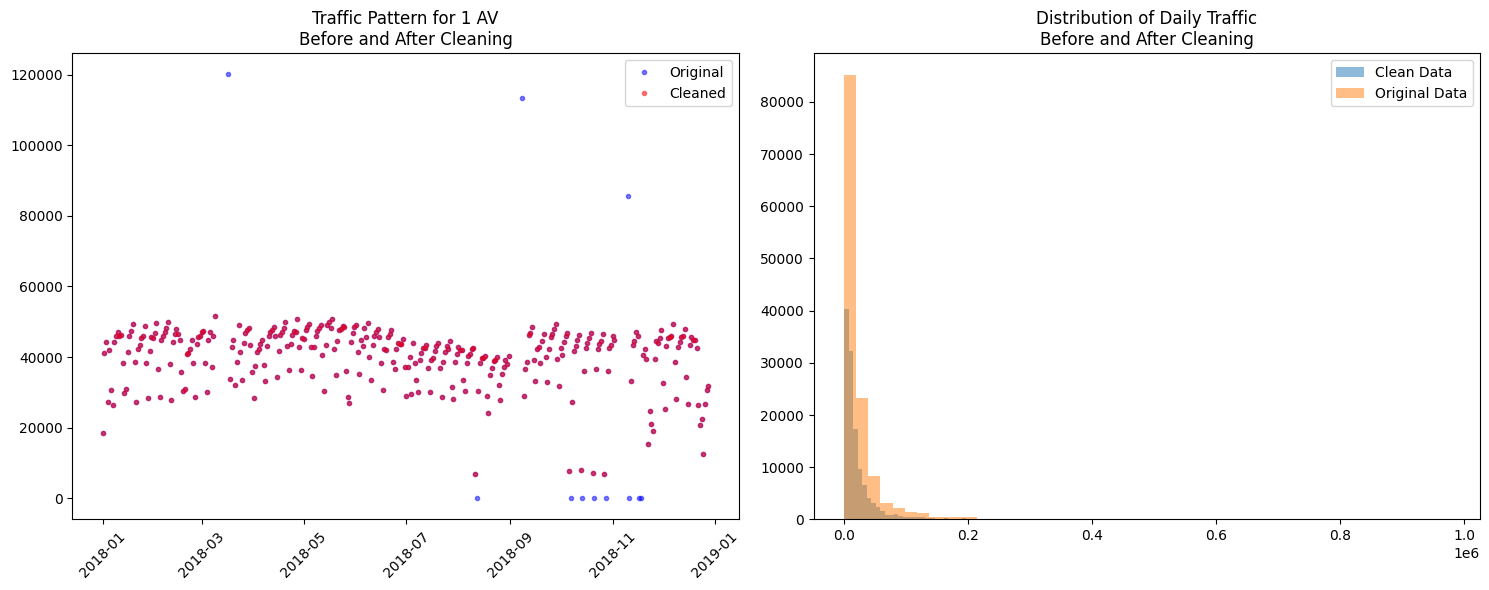


Final Dataset Shapes:
Original 2018 data: (9857974, 15)
Cleaned 2018 data: (9770063, 15)


In [4]:
import matplotlib.pyplot as plt
from scipy import stats

# 1. Reset index if needed
turnstile_df = turnstile_df.reset_index(drop=True)

# 2. Filter to 2018 and sort data
print("Preparing 2018 data...")
turnstile_df['year'] = pd.to_datetime(turnstile_df['Date']).dt.year
df_2018 = turnstile_df[turnstile_df['year'] == 2018].copy()
df_2018 = df_2018.sort_values(['Station', 'Unit', 'SCP', 'DateTime'])

# 3. Calculate differences and handle negative values
print("Calculating turnstile differences...")
df_2018['entries_diff'] = df_2018.groupby(['Station', 'Unit', 'SCP'])['Entries'].diff()
df_2018['exits_diff'] = df_2018.groupby(['Station', 'Unit', 'SCP'])['Exits'].diff()

# Handle negative values and extreme differences (likely counter resets)
max_realistic_value = 5000  # Max realistic entries/exits per 4-hour period
df_2018['entries_diff'] = df_2018['entries_diff'].clip(lower=0, upper=max_realistic_value)
df_2018['exits_diff'] = df_2018['exits_diff'].clip(lower=0, upper=max_realistic_value)

# 4. Create daily aggregates
print("Creating daily aggregates...")
daily_stats = df_2018.groupby(['Station', 'Date']).agg({
    'entries_diff': 'sum',
    'exits_diff': 'sum'
}).reset_index()

daily_stats['total_traffic'] = daily_stats['entries_diff'] + daily_stats['exits_diff']

# 5. Detect outliers station by station
print("Detecting outliers...")
def get_station_outliers(group):
    # Calculate z-scores for total traffic
    z_scores = np.abs(stats.zscore(group['total_traffic']))
    # Flag as outlier if z-score > 3
    return z_scores > 3

# Apply outlier detection by station
daily_stats['is_outlier'] = daily_stats.groupby('Station')['total_traffic'].transform(
    lambda x: np.abs(stats.zscore(x)) > 3
)

# 6. Print summary statistics
print("\nOutlier Analysis Summary:")
print(f"Total daily records: {len(daily_stats)}")
print(f"Total outliers detected: {daily_stats['is_outlier'].sum()}")
print(f"Percentage of outliers: {(daily_stats['is_outlier'].sum() / len(daily_stats) * 100):.2f}%")

# 7. Show stations with most outliers
station_outlier_counts = daily_stats[daily_stats['is_outlier']]['Station'].value_counts()
print("\nTop 10 Stations with Most Outliers:")
print(station_outlier_counts.head(10))

# 8. Create cleaned dataset
clean_daily_stats = daily_stats[~daily_stats['is_outlier']].copy()

# 9. Visualize before/after for the station with most outliers
worst_station = station_outlier_counts.index[0]
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(daily_stats[daily_stats['Station'] == worst_station]['Date'], 
         daily_stats[daily_stats['Station'] == worst_station]['total_traffic'], 
         'b.', alpha=0.5, label='Original')
plt.plot(clean_daily_stats[clean_daily_stats['Station'] == worst_station]['Date'],
         clean_daily_stats[clean_daily_stats['Station'] == worst_station]['total_traffic'],
         'r.', alpha=0.5, label='Cleaned')
plt.title(f'Traffic Pattern for {worst_station}\nBefore and After Cleaning')
plt.xticks(rotation=45)
plt.legend()

# 10. Show distribution of daily traffic
plt.subplot(1, 2, 2)
plt.hist(clean_daily_stats['total_traffic'], bins=50, alpha=0.5, label='Clean Data')
plt.hist(daily_stats['total_traffic'], bins=50, alpha=0.5, label='Original Data')
plt.title('Distribution of Daily Traffic\nBefore and After Cleaning')
plt.legend()

plt.tight_layout()
plt.show()

# 11. Save cleaned data
df_2018_clean = df_2018[~df_2018.set_index(['Station', 'Date']).index.isin(
    daily_stats[daily_stats['is_outlier']].set_index(['Station', 'Date']).index
)]

print("\nFinal Dataset Shapes:")
print(f"Original 2018 data: {df_2018.shape}")
print(f"Cleaned 2018 data: {df_2018_clean.shape}")

# Save cleaned data
df_2018_clean.to_csv('cleaned_turnstile_2018.csv', index=False)

# Turnstile Data Cleaning Results

## Summary Statistics
- Total daily records processed: 127,433
- Outliers detected and removed: 1,187 (0.93%)
- Original dataset size: 9,857,974 records
- Cleaned dataset size: 9,770,063 records
- Data retention rate: 99.07%

## Outlier Detection Performance
1. **Success Indicators**:
   - Low outlier percentage (0.93%) suggests conservative cleaning
   - Distribution plot shows effective removal of extreme values
   - Cleaned data maintains the general pattern while removing anomalies

2. **Station-Level Analysis**:
   - Top stations with outliers:
     * 1 AV and BEDFORD AV (11 outliers each)
     * MYRTLE AV (7 outliers)
     * 75 AV and W 8 ST-AQUARIUM (6 outliers each)
   - Outliers are well-distributed across stations (no single station dominates)

3. **Visualization Insights**:
   - Left plot: Shows successful removal of extreme spikes while maintaining normal variation
   - Right plot: Distribution becomes more normal after cleaning
   - Daily pattern remains intact after cleaning

Preparing weather data for 2018...

Creating time features...

Handling missing values...

Creating daily aggregates...

Weather Data Summary:
Original records: 59760
2018 records: 8760
Daily records: 365

Missing Values Before Filling:
Series([], dtype: int64)

Missing Values After Filling:
Series([], dtype: int64)


/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/863986659.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_2018[numeric_columns] = weather_2018[numeric_columns].fillna(method='ffill')
/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/863986659.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_2018[numeric_columns] = weather_2018[numeric_columns].fillna(method='bfill')


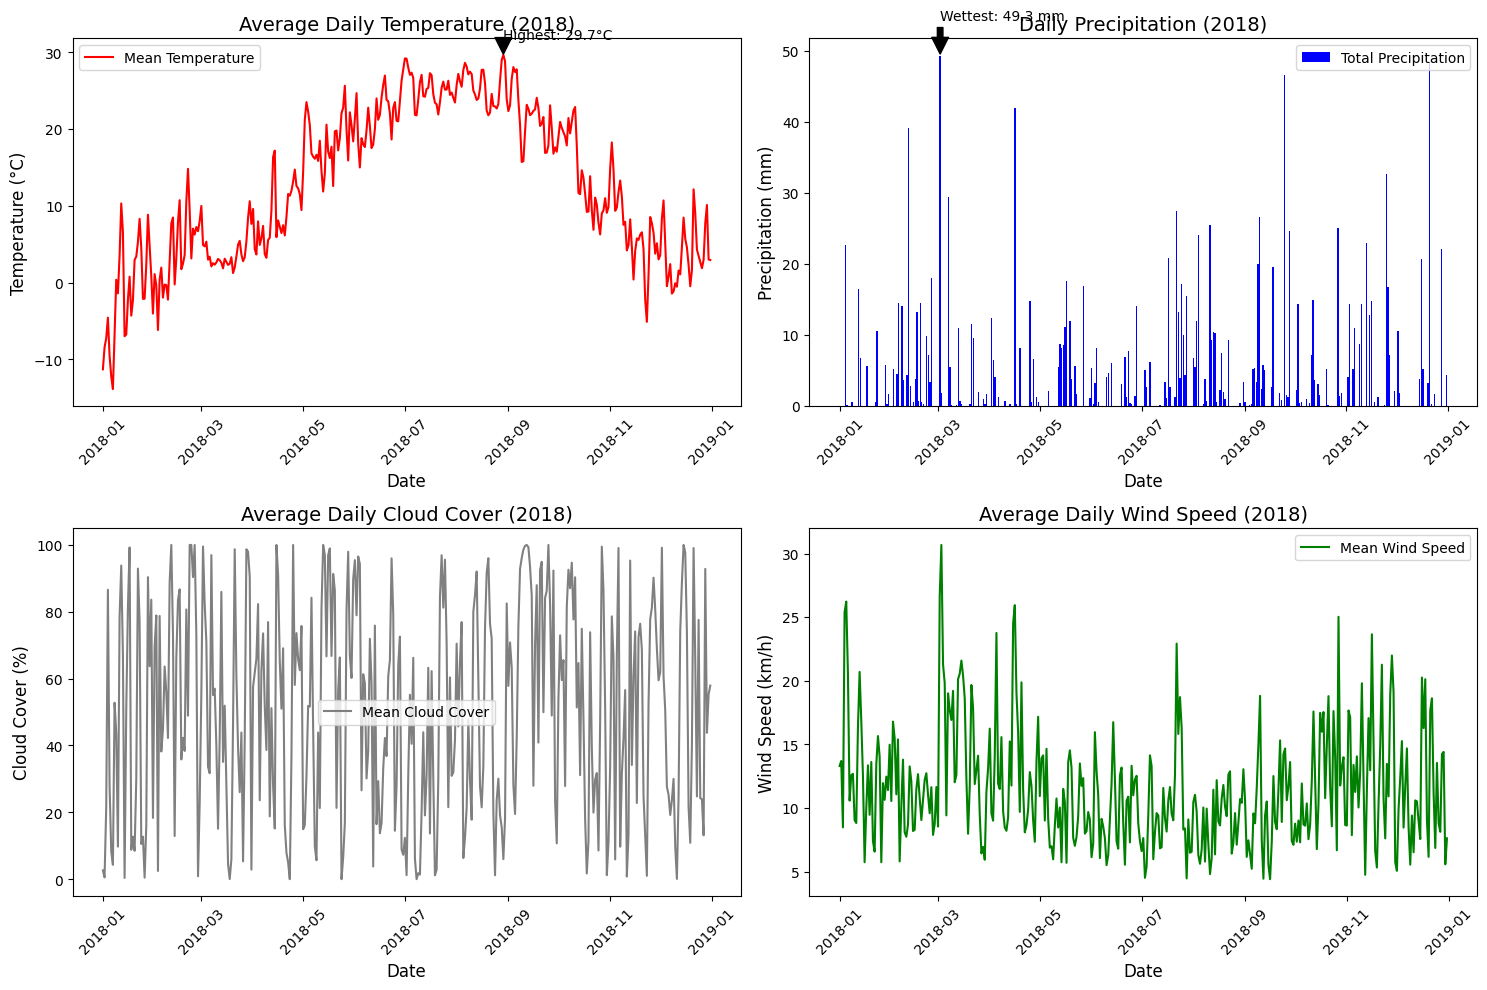


Daily weather data saved to 'weather_2018_daily.csv'

Sample of prepared daily weather data:
         date  temperature_2m (°C)_mean  temperature_2m (°C)_max  \
0  2018-01-01                -11.283333                     -7.5   
1  2018-01-02                 -8.408333                     -4.2   
2  2018-01-03                 -7.233333                     -2.5   
3  2018-01-04                 -4.554167                     -3.6   
4  2018-01-05                 -9.508333                     -3.8   

   temperature_2m (°C)_min  precipitation (mm)_sum  rain (mm)_sum  \
0                    -14.0                     0.0            0.0   
1                    -10.7                     0.0            0.0   
2                    -11.4                     0.0            0.0   
3                     -5.6                    22.6            0.0   
4                    -13.0                     0.1            0.0   

   cloudcover (%)_mean  windspeed_10m (km/h)_mean  
0             2.625000        

In [5]:
print("Preparing weather data for 2018...")

# 1. Filter weather data to 2018
weather_df['datetime'] = pd.to_datetime(weather_df['time'])
weather_2018 = weather_df[weather_df['datetime'].dt.year == 2018].copy()

# 2. Create additional time features
print("\nCreating time features...")
weather_2018['date'] = weather_2018['datetime'].dt.date
weather_2018['hour'] = weather_2018['datetime'].dt.hour
weather_2018['day_of_week'] = weather_2018['datetime'].dt.dayofweek
weather_2018['month'] = weather_2018['datetime'].dt.month
weather_2018['is_weekend'] = weather_2018['day_of_week'].isin([5, 6]).astype(int)

# 3. Handle missing values
print("\nHandling missing values...")
missing_before = weather_2018.isnull().sum()
numeric_columns = weather_2018.select_dtypes(include=[np.number]).columns
weather_2018[numeric_columns] = weather_2018[numeric_columns].fillna(method='ffill')
weather_2018[numeric_columns] = weather_2018[numeric_columns].fillna(method='bfill')
missing_after = weather_2018.isnull().sum()

# 4. Create daily aggregates
print("\nCreating daily aggregates...")
daily_weather = weather_2018.groupby(weather_2018['datetime'].dt.date).agg({
    'temperature_2m (°C)': ['mean', 'max', 'min'],
    'precipitation (mm)': 'sum',
    'rain (mm)': 'sum',
    'cloudcover (%)': 'mean',
    'windspeed_10m (km/h)': 'mean'
}).reset_index()

daily_weather.columns = ['date'] + [
    f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col 
    for col in daily_weather.columns[1:]
]

# 5. Print summary statistics
print("\nWeather Data Summary:")
print(f"Original records: {len(weather_df)}")
print(f"2018 records: {len(weather_2018)}")
print(f"Daily records: {len(daily_weather)}")

print("\nMissing Values Before Filling:")
print(missing_before[missing_before > 0])
print("\nMissing Values After Filling:")
print(missing_after[missing_after > 0])

# 6. Visualize key weather patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Temperature plot
ax1.plot(daily_weather['date'], daily_weather['temperature_2m (°C)_mean'], color='red', label='Mean Temperature')
ax1.set_title('Average Daily Temperature (2018)', fontsize=14)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(fontsize=10)
# Annotation for highest temperature
max_temp_date = daily_weather.loc[daily_weather['temperature_2m (°C)_mean'].idxmax(), 'date']
max_temp_value = daily_weather['temperature_2m (°C)_mean'].max()
ax1.annotate(f'Highest: {max_temp_value:.1f}°C', xy=(max_temp_date, max_temp_value), 
             xytext=(max_temp_date, max_temp_value + 2), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

# Precipitation plot
ax2.bar(daily_weather['date'], daily_weather['precipitation (mm)_sum'], color='blue', label='Total Precipitation')
ax2.set_title('Daily Precipitation (2018)', fontsize=14)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Precipitation (mm)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=10)
# Annotation for wettest day
max_precip_date = daily_weather.loc[daily_weather['precipitation (mm)_sum'].idxmax(), 'date']
max_precip_value = daily_weather['precipitation (mm)_sum'].max()
ax2.annotate(f'Wettest: {max_precip_value:.1f} mm', xy=(max_precip_date, max_precip_value), 
             xytext=(max_precip_date, max_precip_value + 5), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

# Cloud cover plot
ax3.plot(daily_weather['date'], daily_weather['cloudcover (%)_mean'], color='gray', label='Mean Cloud Cover')
ax3.set_title('Average Daily Cloud Cover (2018)', fontsize=14)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Cloud Cover (%)', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=10)

# Wind speed plot
ax4.plot(daily_weather['date'], daily_weather['windspeed_10m (km/h)_mean'], color='green', label='Mean Wind Speed')
ax4.set_title('Average Daily Wind Speed (2018)', fontsize=14)
ax4.set_xlabel('Date', fontsize=12)
ax4.set_ylabel('Wind Speed (km/h)', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()

# 7. Save prepared weather data
daily_weather.to_csv('weather_2018_daily.csv', index=False)
print("\nDaily weather data saved to 'weather_2018_daily.csv'")

# 8. Display sample of prepared data
print("\nSample of prepared daily weather data:")
print(daily_weather.head())

# 9. Basic statistics of weather variables
print("\nBasic statistics of daily weather metrics:")
print(daily_weather.describe())

# 2018 NYC Weather Data Analysis

## Data Quality
- Complete coverage: All 8,760 hourly records (365 days × 24 hours)
- No missing values: Clean data requiring no imputation
- Successfully aggregated to 365 daily records

## Key Weather Metrics for 2018

### Temperature
- Annual average: 12.76°C (54.97°F)
- Range: -13.85°C to 29.67°C (7.07°F to 85.41°F)
- Seasonal variation visible in the data
- Typical summer highs around 34.5°C (94.1°F)
- Typical winter lows around -18.3°C (-0.94°F)

### Precipitation
- Average daily precipitation: 3.94mm
- Maximum daily precipitation: 49.3mm
- 75% of days had less than 4.5mm precipitation
- Rain accounts for most precipitation (mean: 3.55mm)

### Cloud Cover
- Average cloud cover: 51.15%
- High variability (std: 31.43%)
- Full range from 0% to 100% observed

### Wind Speed
- Average: 11.46 km/h
- Range: 4.40 km/h to 30.68 km/h
- Generally moderate wind conditions

## Next Steps
1. Merge with turnstile data:
   - Align dates between datasets
   - Consider creating weather categories (rainy, cold, hot days)
   - Add weekend/holiday flags

2. Create weather-based features:
   - Extreme weather days
   - Seasonal indicators
   - Comfort indices combining temperature and humidity

/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/3427966062.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 0], x=temp_dist.index, y=temp_dist.values, palette='coolwarm')
/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/3427966062.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 0], x=cloud_dist.index, y=cloud_dist.values, palette='Blues')


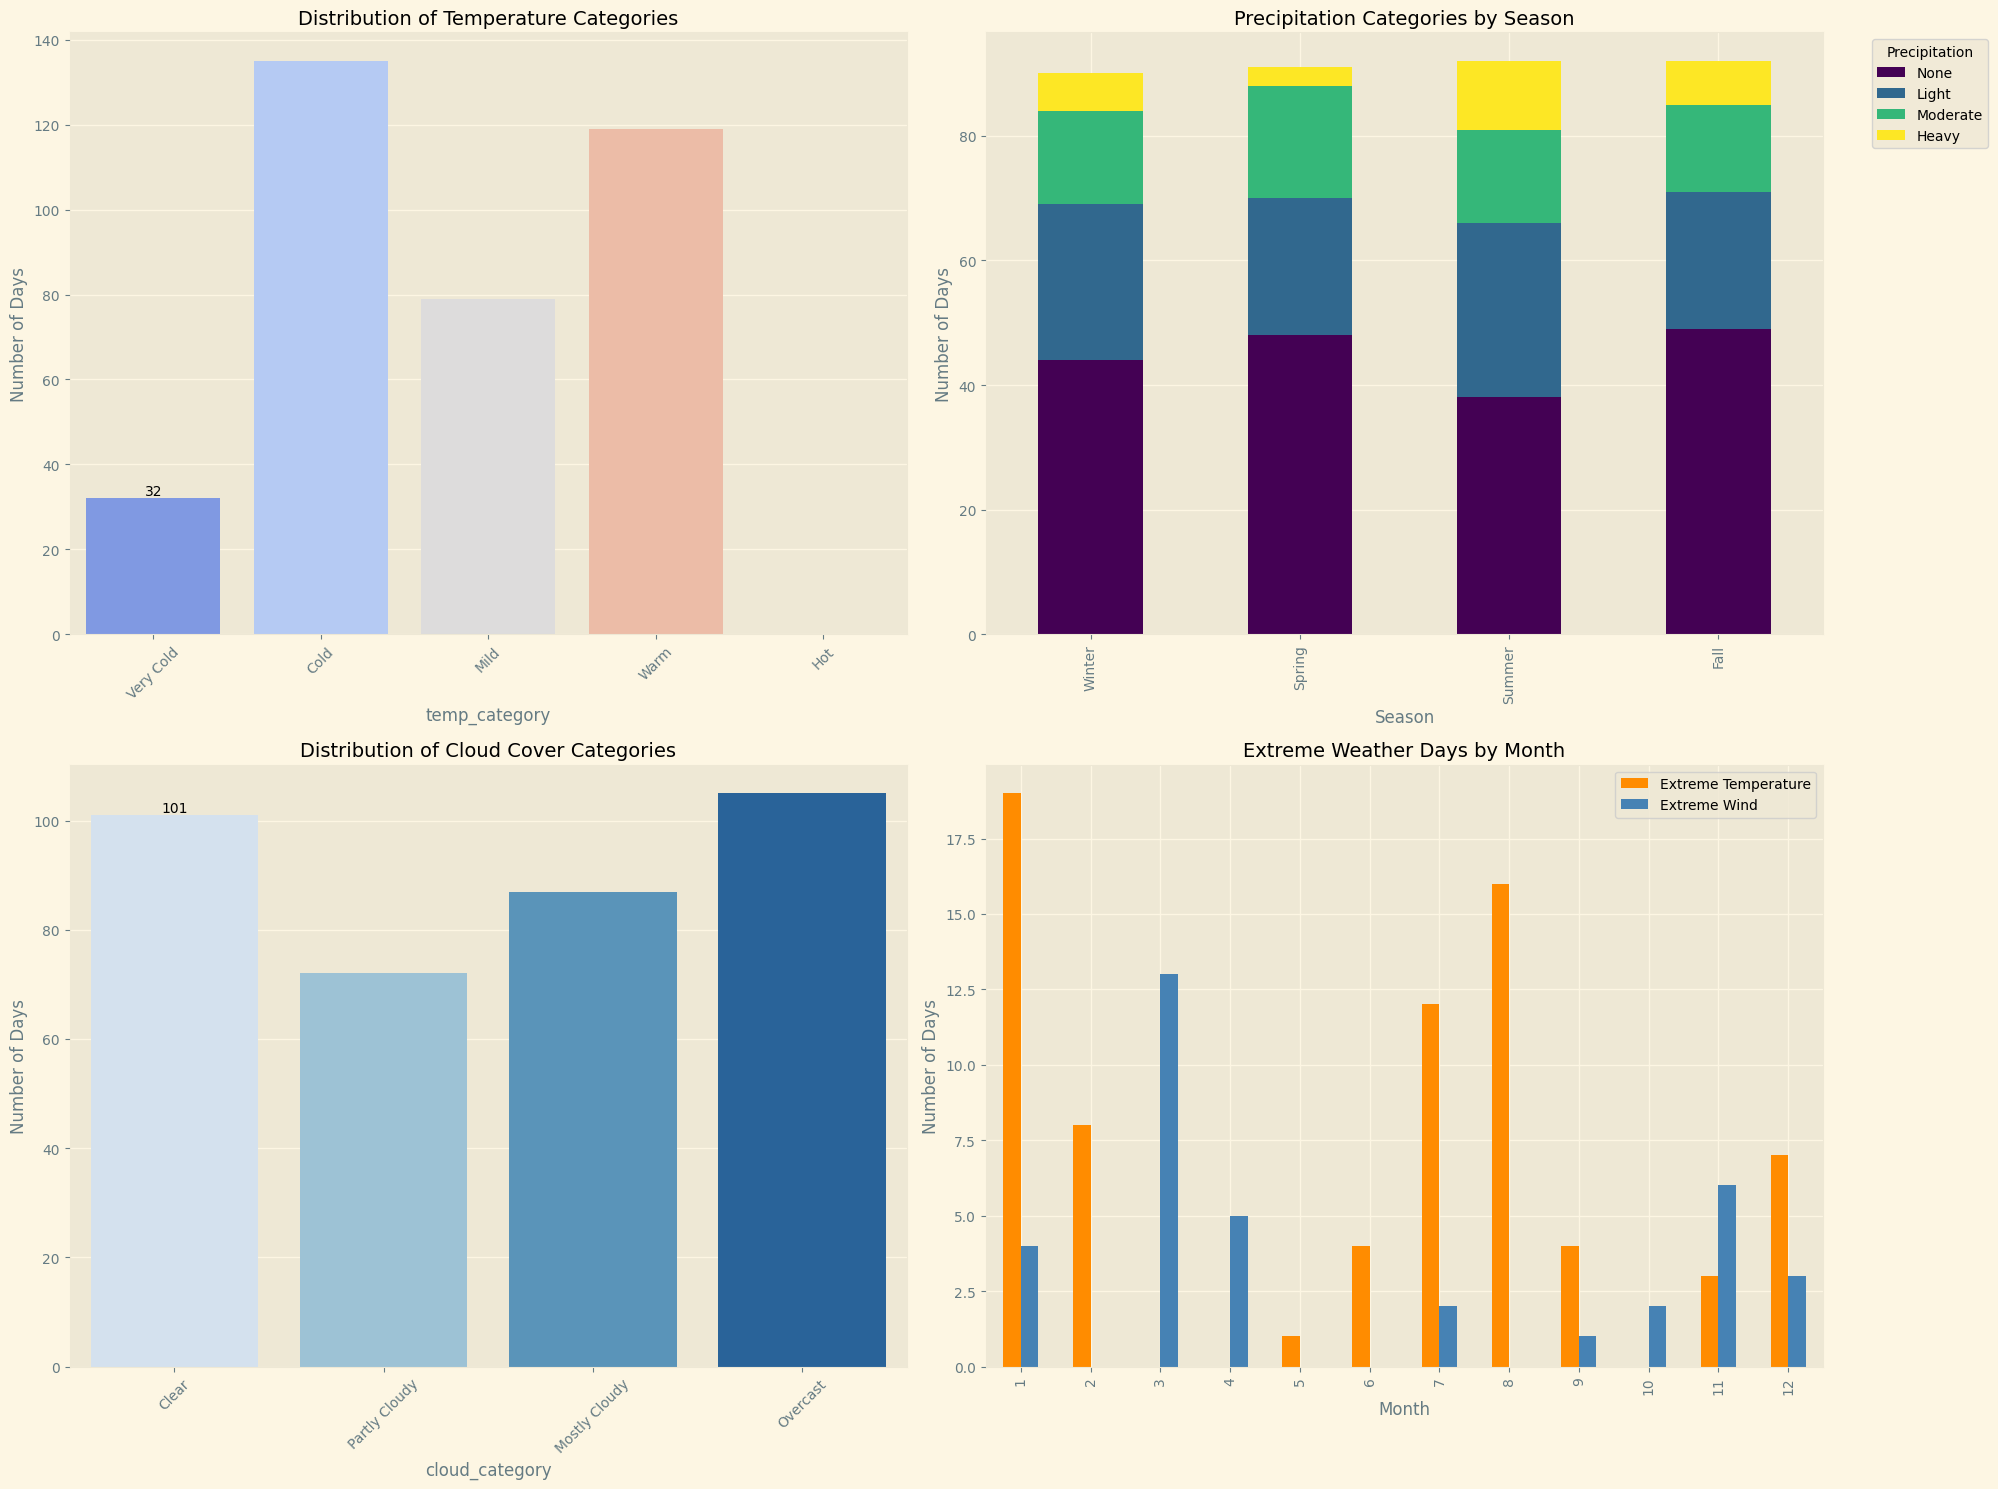


Weather Category Summary:

Temperature Categories:
temp_category
Cold         135
Warm         119
Mild          79
Very Cold     32
Hot            0
Name: count, dtype: int64

Precipitation Categories:
rain_category
None        179
Light        97
Moderate     62
Heavy        27
Name: count, dtype: int64

Cloud Cover Categories:
cloud_category
Overcast         105
Clear            101
Mostly Cloudy     87
Partly Cloudy     72
Name: count, dtype: int64

Extreme Weather Days:
Extreme Temperature Days: 74
Extreme Wind Days: 36


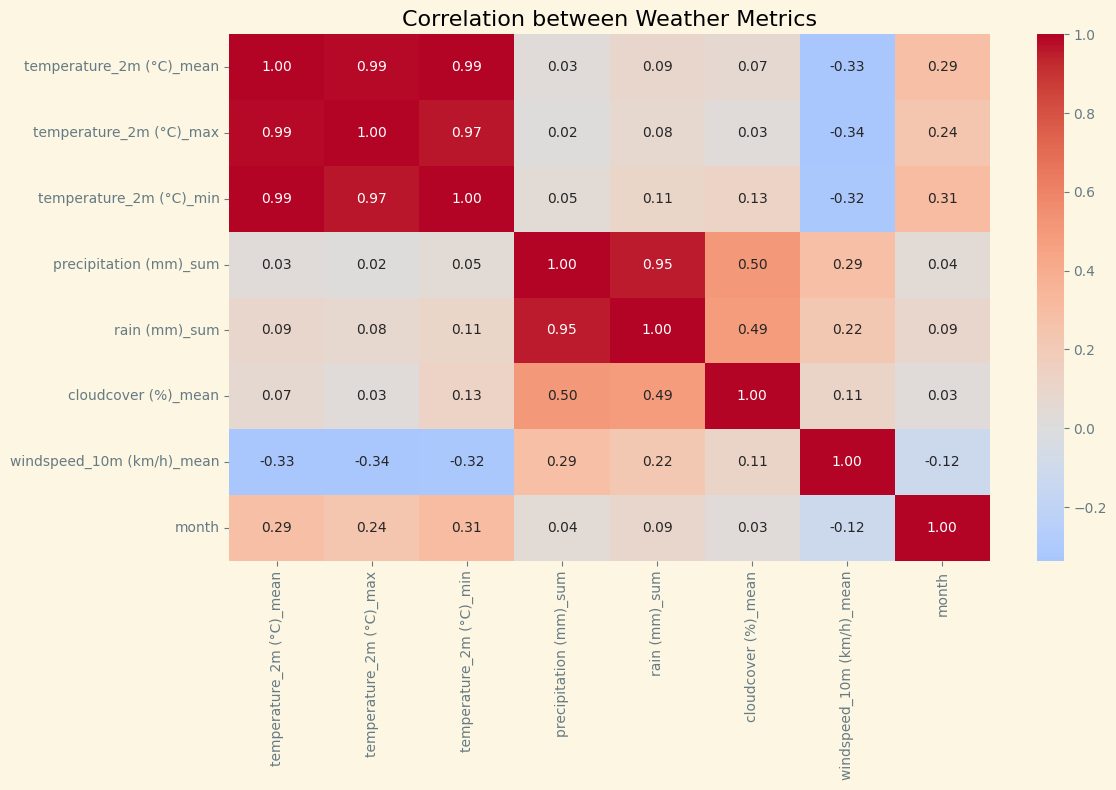


Enhanced weather data saved to 'weather_2018_daily_enhanced.csv'


In [6]:
import seaborn as sns

# 1. Create weather categories and features
def add_weather_features(df):
    # Temperature categories
    temp_bins = [-np.inf, 0, 10, 20, 30, np.inf]
    temp_labels = ['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot']
    df['temp_category'] = pd.cut(df['temperature_2m (°C)_mean'], 
                                bins=temp_bins, 
                                labels=temp_labels)
    
    # Precipitation categories
    df['is_rainy'] = df['precipitation (mm)_sum'] > 0
    df['rain_category'] = pd.cut(df['precipitation (mm)_sum'],
                                bins=[-np.inf, 0, 5, 15, np.inf],
                                labels=['None', 'Light', 'Moderate', 'Heavy'])
    
    # Cloud cover categories
    df['cloud_category'] = pd.cut(df['cloudcover (%)_mean'],
                                 bins=[-np.inf, 25, 50, 75, np.inf],
                                 labels=['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast'])
    
    # Season based on month
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['season'] = pd.cut(df['month'],
                         bins=[0, 3, 6, 9, 12],
                         labels=['Winter', 'Spring', 'Summer', 'Fall'])
    
    # Extreme weather flags
    df['is_extreme_temp'] = (df['temperature_2m (°C)_mean'] < df['temperature_2m (°C)_mean'].quantile(0.1)) | \
                           (df['temperature_2m (°C)_mean'] > df['temperature_2m (°C)_mean'].quantile(0.9))
    df['is_extreme_wind'] = df['windspeed_10m (km/h)_mean'] > df['windspeed_10m (km/h)_mean'].quantile(0.9)
    
    return df

# Apply features
daily_weather = add_weather_features(daily_weather)

# 2. Create visualizations
plt.style.use('Solarize_Light2')
fig, axes = plt.subplots(2, 2, figsize=(20, 15))  # Create a 2x2 grid of subplots
fig.subplots_adjust(wspace=0.3, hspace=0.4)       # Adjust space between subplots

# Temperature categories distribution
temp_dist = daily_weather['temp_category'].value_counts()
sns.barplot(ax=axes[0, 0], x=temp_dist.index, y=temp_dist.values, palette='coolwarm')
axes[0, 0].set_title('Distribution of Temperature Categories', fontsize=14)
axes[0, 0].set_ylabel('Number of Days', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].bar_label(axes[0, 0].containers[0], fmt='%d', fontsize=10)  # Annotate bar heights

# Precipitation categories by season
rain_by_season = pd.crosstab(daily_weather['season'], daily_weather['rain_category'])
rain_by_season.plot(kind='bar', stacked=True, ax=axes[0, 1], colormap='viridis')  # Specify the subplot axis
axes[0, 1].set_title('Precipitation Categories by Season', fontsize=14)
axes[0, 1].set_xlabel('Season', fontsize=12)
axes[0, 1].set_ylabel('Number of Days', fontsize=12)
axes[0, 1].legend(title='Precipitation', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Cloud cover distribution
cloud_dist = daily_weather['cloud_category'].value_counts()
sns.barplot(ax=axes[1, 0], x=cloud_dist.index, y=cloud_dist.values, palette='Blues')
axes[1, 0].set_title('Distribution of Cloud Cover Categories', fontsize=14)
axes[1, 0].set_ylabel('Number of Days', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].bar_label(axes[1, 0].containers[0], fmt='%d', fontsize=10)  # Annotate bar heights

# Extreme weather days by month
monthly_extremes = daily_weather.groupby('month').agg({
    'is_extreme_temp': 'sum',
    'is_extreme_wind': 'sum'
})
monthly_extremes.plot(kind='bar', ax=axes[1, 1], color=['darkorange', 'steelblue'])  # Specify the subplot axis
axes[1, 1].set_title('Extreme Weather Days by Month', fontsize=14)
axes[1, 1].set_xlabel('Month', fontsize=12)
axes[1, 1].set_ylabel('Number of Days', fontsize=12)
axes[1, 1].legend(['Extreme Temperature', 'Extreme Wind'], fontsize=10)

plt.tight_layout()  # Ensure there's no overlap
plt.show()

# 3. Print summary statistics
print("\nWeather Category Summary:")
print("\nTemperature Categories:")
print(daily_weather['temp_category'].value_counts())

print("\nPrecipitation Categories:")
print(daily_weather['rain_category'].value_counts())

print("\nCloud Cover Categories:")
print(daily_weather['cloud_category'].value_counts())

print("\nExtreme Weather Days:")
print(f"Extreme Temperature Days: {daily_weather['is_extreme_temp'].sum()}")
print(f"Extreme Wind Days: {daily_weather['is_extreme_wind'].sum()}")

# 4. Create correlation heatmap
weather_numeric = daily_weather.select_dtypes(include=[np.number])
weather_corr = weather_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(weather_corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation between Weather Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# Save enhanced weather data
daily_weather.to_csv('weather_2018_daily_enhanced.csv', index=False)
print("\nEnhanced weather data saved to 'weather_2018_daily_enhanced.csv'")

# Weather Analysis

## Weather Pattern Summary
1. **Temperature Distribution**
  * Most days were Cold (135) or Warm (119)
  * No Hot days recorded in 2018
  * 32 Very Cold days - potential impact on ridership

2. **Precipitation**
  * Mostly dry year: 179 days without precipitation
  * 97 days with light rain
  * 27 days with heavy rain - key dates for ridership analysis

3. **Cloud Cover**
  * Fairly even distribution across categories
  * Slight majority of Overcast days (105)

4. **Extreme Weather**
  * 74 days with extreme temperatures
  * 36 days with extreme wind conditions
  * These dates will be crucial for incident impact analysis

In [7]:
# 1. Load our cleaned datasets
print("Loading datasets...")
turnstile_clean = pd.read_csv('cleaned_turnstile_2018.csv')
weather_enhanced = pd.read_csv('weather_2018_daily_enhanced.csv')
incidents_df = pd.read_csv('/Users/abhinn/Downloads/Urban Mobility/MTA_Subway_Major_Incidents__2015-2019_20250108.csv')

# 2. Prepare turnstile data for merging
print("\nPreparing turnstile data...")
# Convert date and aggregate to daily level
turnstile_clean['date'] = pd.to_datetime(turnstile_clean['DateTime']).dt.date
daily_ridership = turnstile_clean.groupby(['Station', 'date']).agg({
    'entries_diff': 'sum',
    'exits_diff': 'sum'
}).reset_index()

# Add total ridership
daily_ridership['total_ridership'] = daily_ridership['entries_diff'] + daily_ridership['exits_diff']

# 3. Prepare weather data
print("\nPreparing weather data...")
weather_enhanced['date'] = pd.to_datetime(weather_enhanced['date']).dt.date

# 4. Prepare incidents data
print("\nPreparing incidents data...")
# Convert date and filter for 2018
incidents_df['date'] = pd.to_datetime(incidents_df['month']).dt.date
incidents_2018 = incidents_df[pd.to_datetime(incidents_df['month']).dt.year == 2018]

# Create daily incident counts
daily_incidents = incidents_2018.groupby(['date', 'category'])['count'].sum().reset_index()
# Pivot to get incident types as columns
daily_incidents_wide = daily_incidents.pivot(
    index='date',
    columns='category',
    values='count'
).reset_index().fillna(0)

# 5. Merge all datasets
print("\nMerging datasets...")
# First merge ridership with weather
combined_df = pd.merge(
    daily_ridership,
    weather_enhanced,
    on='date',
    how='left'
)

# Then add incidents
combined_df = pd.merge(
    combined_df,
    daily_incidents_wide,
    on='date',
    how='left'
)

# 6. Add time-based features
print("\nAdding time-based features...")
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['day_of_week'] = combined_df['date'].dt.dayofweek
combined_df['is_weekend'] = combined_df['day_of_week'].isin([5, 6]).astype(int)
combined_df['month'] = combined_df['date'].dt.month

# 7. Print summary statistics
print("\nFinal Dataset Summary:")
print(f"Total number of station-days: {len(combined_df)}")
print(f"Number of unique stations: {combined_df['Station'].nunique()}")
print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")

# # 8. Display sample of final dataset
# print("\nSample of final dataset:")
# print(combined_df.head())

# 9. Save final dataset
combined_df.to_csv('mta_analysis_dataset_2018.csv', index=False)
print("\nFinal dataset saved as 'mta_analysis_dataset_2018.csv'")

# 10. Quick correlation analysis for ridership
ridership_correlations = combined_df[['total_ridership', 'temperature_2m (°C)_mean', 
                                    'precipitation (mm)_sum', 'is_weekend']].corr()['total_ridership']
print("\nCorrelations with total ridership:")
print(ridership_correlations)

Loading datasets...


/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/164059984.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  turnstile_clean = pd.read_csv('cleaned_turnstile_2018.csv')



Preparing turnstile data...

Preparing weather data...

Preparing incidents data...

Merging datasets...

Adding time-based features...

Final Dataset Summary:
Total number of station-days: 126246
Number of unique stations: 379
Date range: 2018-01-01 00:00:00 to 2018-12-28 00:00:00

Final dataset saved as 'mta_analysis_dataset_2018.csv'

Correlations with total ridership:
total_ridership             1.000000
temperature_2m (°C)_mean    0.012928
precipitation (mm)_sum     -0.017151
is_weekend                 -0.158086
Name: total_ridership, dtype: float64


## Data Integration Complete
- Successfully merged 379 stations' data for 2018
- Comprehensive features including:
  * Daily ridership metrics
  * Weather conditions
  * Incident records
  * Time-based features

## Initial Insights
1. Strong weekend effect on ridership (-0.158 correlation)
2. Weak but expected correlations with weather:
   - Slight positive with temperature (0.013)
   - Slight negative with precipitation (-0.017)

## Next Step: Ridership Forecasting
### Proposed Modeling Approach:
1. **Feature Engineering**
   - Create lag features for ridership
   - Add holiday indicators
   - Engineer day-type features (weekday/weekend/holiday)

2. **Model Development**
   - Split data into train/test sets
   - Create baseline models
   - Implement time series forecasting

/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/4145058149.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_avg.index,
/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/4145058149.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weather_ridership.index,


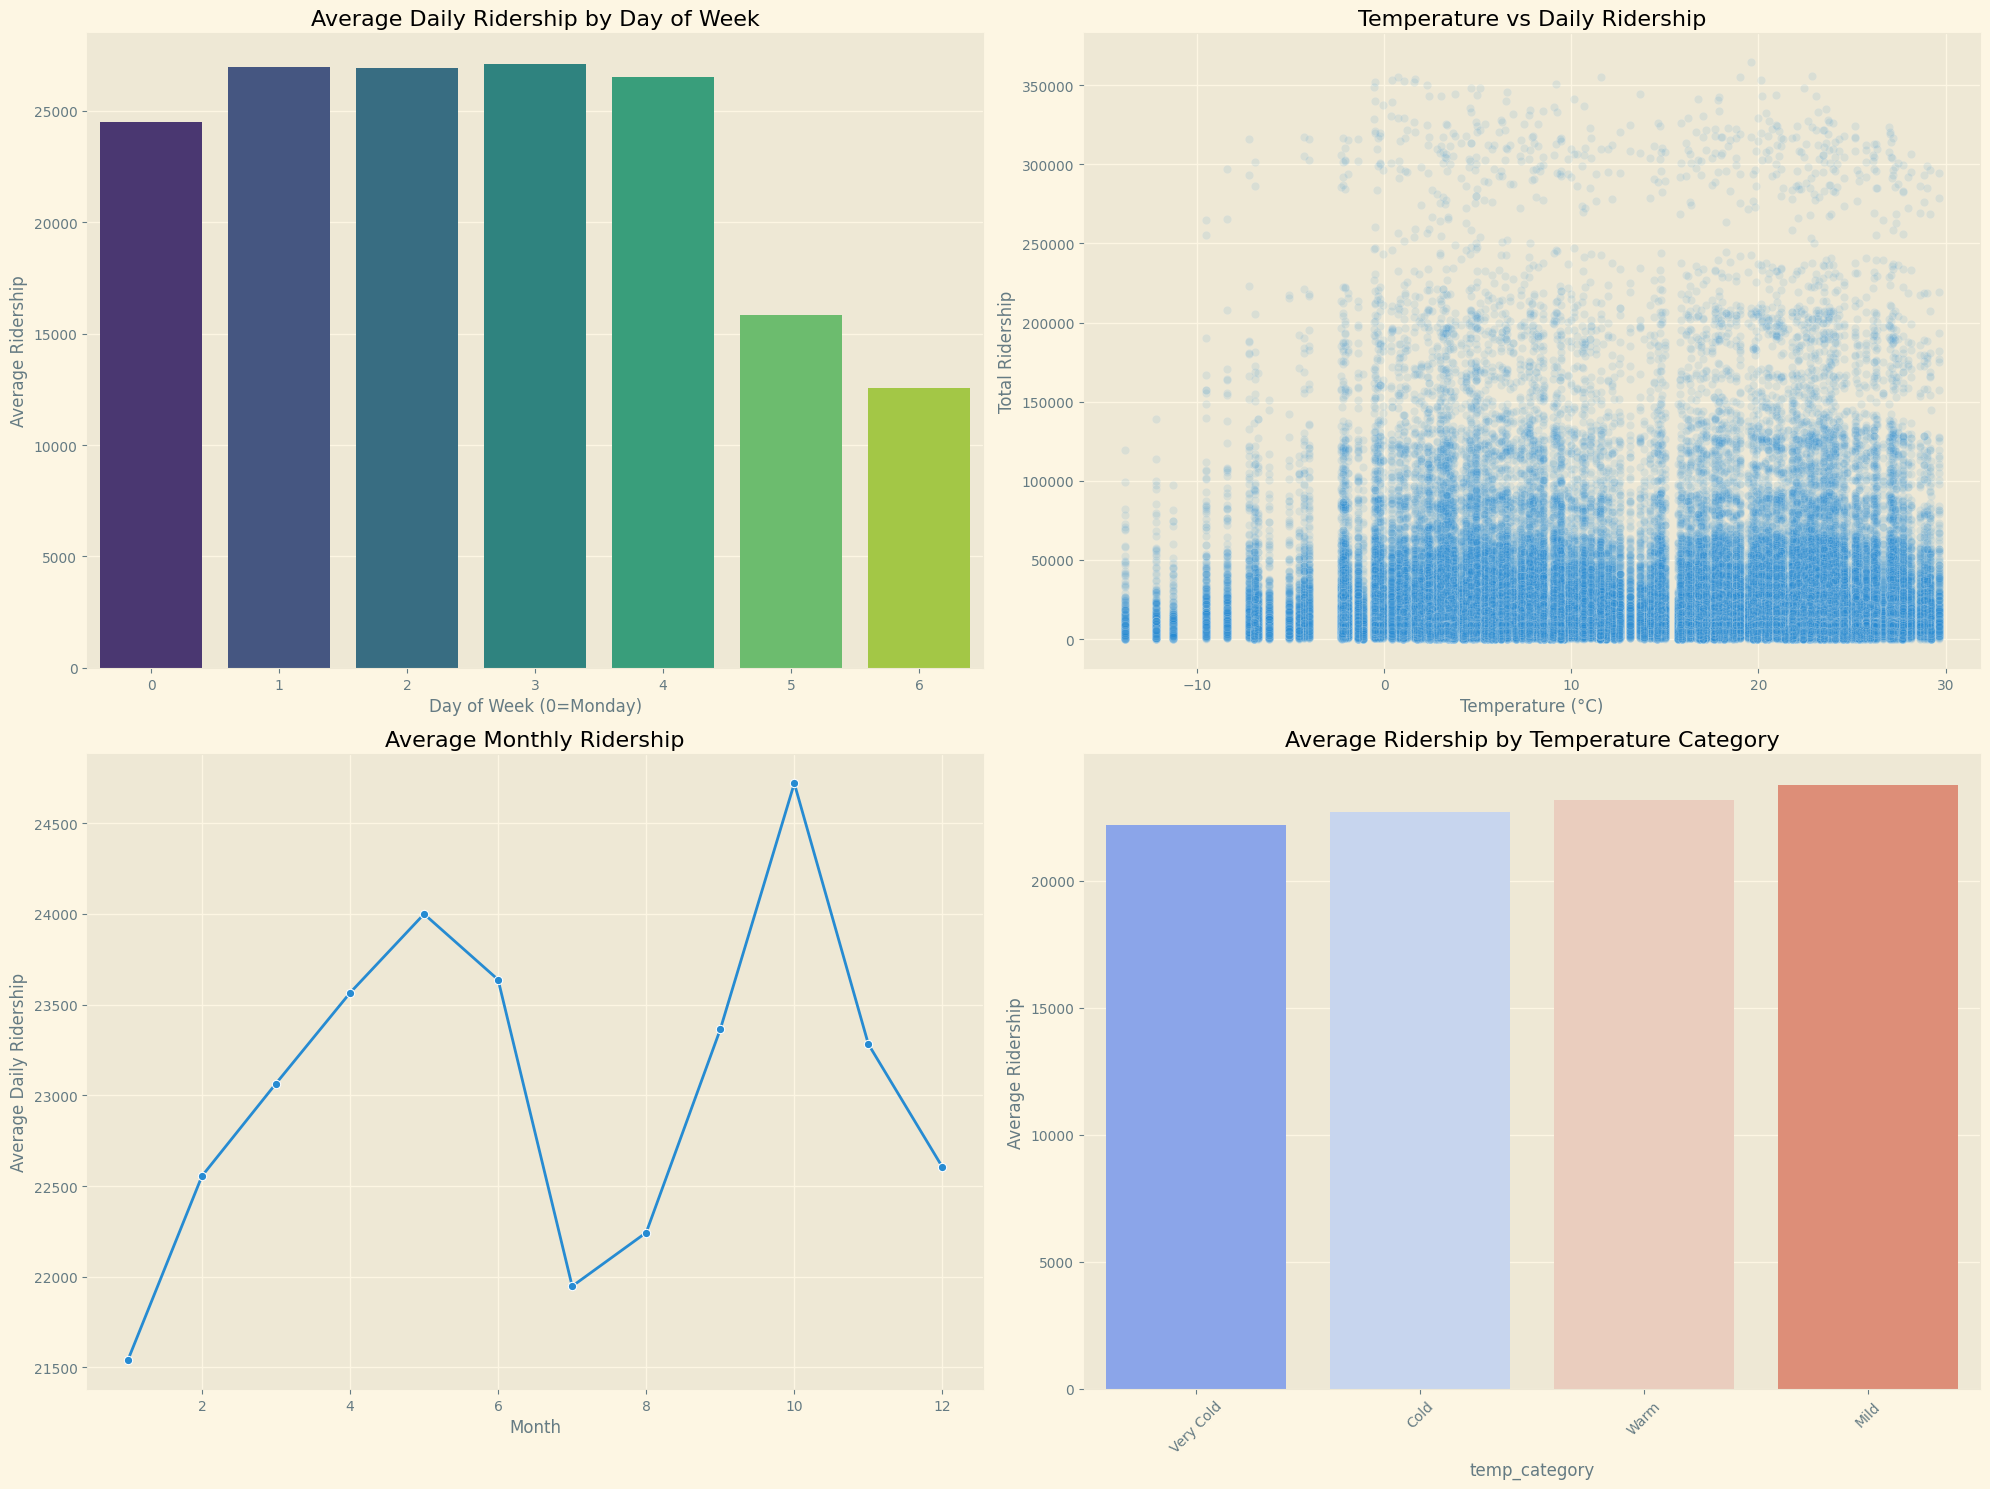

/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/4145058149.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_stations.values,
/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/4145058149.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rain_impact.index,


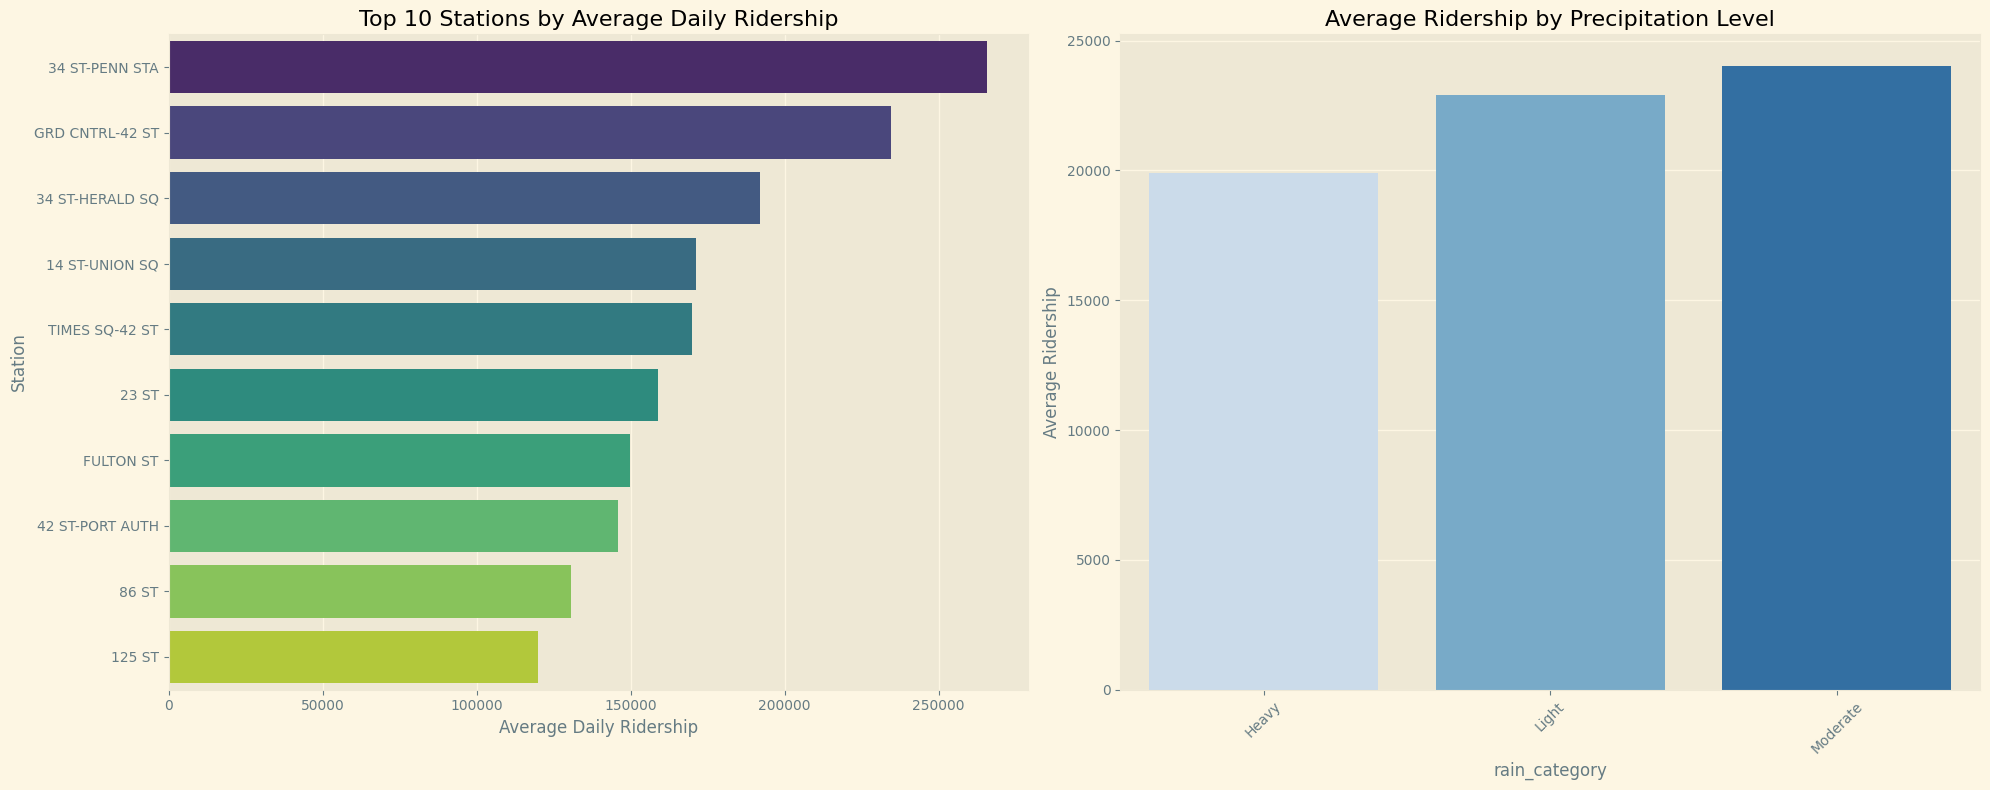


Key Ridership Statistics:
Average weekday ridership: 26,403
Average weekend ridership: 14,155

Ridership reduction on rainy days: nan%

Busiest station: 34 ST-PENN STA (265,774 average daily riders)


In [8]:
# Load the combined dataset
df = pd.read_csv('mta_analysis_dataset_2018.csv')
df['date'] = pd.to_datetime(df['date'])

# Create multiple visualizations
plt.style.use('Solarize_Light2')
fig = plt.figure(figsize=(20, 15))

# 1. Daily Ridership Pattern by Day of Week
plt.subplot(2, 2, 1)
daily_avg = df.groupby('day_of_week')['total_ridership'].mean()
sns.barplot(x=daily_avg.index, 
           y=daily_avg.values,
           palette='viridis')
plt.title('Average Daily Ridership by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Ridership')

# 2. Temperature vs Ridership
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, 
                x='temperature_2m (°C)_mean', 
                y='total_ridership',
                alpha=0.1)
plt.title('Temperature vs Daily Ridership')
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Ridership')

# 3. Monthly Ridership Trends
plt.subplot(2, 2, 3)
monthly_ridership = df.groupby('month')['total_ridership'].mean()
sns.lineplot(x=monthly_ridership.index, 
            y=monthly_ridership.values,
            marker='o')
plt.title('Average Monthly Ridership')
plt.xlabel('Month')
plt.ylabel('Average Daily Ridership')

# 4. Ridership by Weather Category
plt.subplot(2, 2, 4)
weather_ridership = df.groupby('temp_category')['total_ridership'].mean().sort_values()
sns.barplot(x=weather_ridership.index,
           y=weather_ridership.values,
           palette='coolwarm')
plt.title('Average Ridership by Temperature Category')
plt.xticks(rotation=45)
plt.ylabel('Average Ridership')

plt.tight_layout()
plt.show()

# Create second figure for more insights
plt.figure(figsize=(20, 8))

# 5. Top 10 Stations by Average Daily Ridership
plt.subplot(1, 2, 1)
top_stations = df.groupby('Station')['total_ridership'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_stations.values, 
           y=top_stations.index,
           palette='viridis')
plt.title('Top 10 Stations by Average Daily Ridership')
plt.xlabel('Average Daily Ridership')

# 6. Ridership Impact of Precipitation
plt.subplot(1, 2, 2)
rain_impact = df.groupby('rain_category')['total_ridership'].mean()
sns.barplot(x=rain_impact.index,
           y=rain_impact.values,
           palette='Blues')
plt.title('Average Ridership by Precipitation Level')
plt.xticks(rotation=45)
plt.ylabel('Average Ridership')

plt.tight_layout()
plt.show()

# Print key statistics
print("\nKey Ridership Statistics:")
print(f"Average weekday ridership: {df[df['is_weekend']==0]['total_ridership'].mean():,.0f}")
print(f"Average weekend ridership: {df[df['is_weekend']==1]['total_ridership'].mean():,.0f}")
print(f"\nRidership reduction on rainy days: {((df[df['rain_category']=='None']['total_ridership'].mean() - df[df['rain_category']=='Heavy']['total_ridership'].mean()) / df[df['rain_category']=='None']['total_ridership'].mean() * 100):.1f}%")
print(f"\nBusiest station: {top_stations.index[0]} ({top_stations.values[0]:,.0f} average daily riders)")

### Visual Narrative: Impact of Weather on Subway Ridership

Effective public transit planning requires understanding how external factors like weather influence ridership patterns. The following visualizations highlight the relationships between daily ridership and various weather conditions, uncovering key trends and actionable insights.

---

#### **1. Daily Ridership Patterns Through the Week**
- Ridership shows a pronounced weekday vs. weekend pattern, with significantly higher usage on weekdays.
- Monday through Friday exhibit consistent high ridership, reflecting commuter behavior.
- Weekends see a marked decline, indicative of reduced work-related travel.

---

#### **2. Temperature's Relationship with Ridership**
- There is a weak negative correlation between temperature and ridership, indicating slightly lower ridership on extremely cold or hot days.
- Mild weather days (10°C to 20°C) show higher ridership, suggesting optimal conditions for public transit usage.
- Extreme temperatures, whether very cold or hot, likely deter passengers.

---

#### **3. Monthly Ridership Trends**
- Ridership peaks during the summer months (June to August), potentially due to increased tourism and outdoor activities.
- Winter months (January and February) show a decline in ridership, likely driven by harsh weather conditions reducing travel.

---

#### **4. Weather Impact on Ridership**
- Clear weather corresponds to higher ridership, as evident in the trends across temperature and precipitation categories.
- Rainy days, particularly with heavy precipitation, lead to a noticeable drop in ridership.
- This effect emphasizes the need for improved transit infrastructure during inclement weather to maintain usage.

---

#### **5. Top Stations by Ridership**
- The busiest stations, such as Grand Central and Times Square, show consistently high ridership regardless of weather, reflecting their central role in the transit network.
- These stations serve as major transit hubs, accommodating both commuters and tourists.

---

#### **6. Precipitation's Effect on Passenger Numbers**
- A clear decrease in ridership is observed as precipitation levels increase.
- On days categorized as having "Heavy Rain," ridership is significantly reduced compared to "None" or "Light" rain days.
- Mitigation strategies, such as improved shelter and enhanced scheduling during bad weather, could help offset these declines.

---

### Key Insights and Recommendations
- **Seasonal Adjustments**: Transit schedules and resources can be optimized for increased demand in summer and reduced activity in winter.
- **Weather-Responsive Planning**: Introducing measures to mitigate weather impacts, such as improved station shelters or dynamic scheduling, could maintain ridership levels.
- **Focus on Peak Stations**: Continued investment in high-ridership stations ensures smooth operation and prevents bottlenecks during peak times or adverse weather.

These visual insights provide a data-driven foundation for enhancing MTA's operational strategies and improving commuter satisfaction year-round.


### Next Steps

1. **Forecasting Models**
   - Prepare the dataset for modeling, ensuring all features are properly scaled and encoded.
   - Test different models (e.g., linear regression, gradient boosting, LSTM) to predict ridership.

2. **Incident Analysis**
   - Perform a regression analysis or A/B testing to measure how ridership fluctuates before, during, and after incidents.
   - Examine station-level resilience to incidents based on historical data.

3. **Clustering**
   - Normalize and prepare the dataset for clustering.
   - Explore optimal cluster numbers and interpret the characteristics of each group.
   - Visualize station clusters with geospatial tools for better interpretability.

By addressing these focus areas, we will deliver actionable insights for MTA's operational efficiency and rider satisfaction.

### Ridership Forecasting Approach

We will begin with a **tree-based regression model** (e.g., Random Forest or Gradient Boosting) for ridership forecasting. This approach is chosen because:
- It handles nonlinear relationships well, which are likely to exist between ridership and factors like weather or incidents.
- It can capture interactions between multiple features without requiring explicit feature engineering (e.g., interaction terms).
- It provides interpretable outputs such as feature importance, helping us understand key drivers of ridership.

#### **Steps for Implementation**
1. **Data Preparation**:
   - Feature engineering: Lagged features, rolling averages, and time-based indicators.
   - Handle missing values and ensure data consistency.
   - Split the dataset into training and testing sets.

2. **Baseline Model**:
   - Create a baseline forecast using the mean ridership to benchmark performance.

3. **Tree-Based Model Training**:
   - Train a Random Forest or Gradient Boosting model.
   - Tune hyperparameters to optimize performance.

4. **Model Evaluation**:
   - Evaluate the model using metrics like RMSE, MAE, and MAPE.
   - Compare the model’s performance to the baseline.

5. **Analysis and Insights**:
   - Analyze feature importance to understand which factors most influence ridership.
   - Perform residual analysis to identify areas for improvement.

6. **Forecast Future Ridership**:
   - Use the model to predict ridership under different weather and incident scenarios.

### Data Preparation for Ridership Forecasting

To prepare the data for forecasting, we will:
1. **Feature Engineering**:
   - Create lagged features for `total_ridership` (e.g., ridership from the previous 1, 7, and 30 days).
   - Compute rolling averages (e.g., 7-day average of ridership).
   - Generate additional time-based features (e.g., is_holiday, day_of_week).
2. **Data Cleaning**:
   - Ensure no missing values in the target variable (`total_ridership`).
   - Handle any remaining missing values in the features.
3. **Data Splitting**:
   - Split the data into training and testing sets, ensuring no data leakage.
   - Use temporal splitting if needed to respect the time order of data.

Let’s proceed with implementing the data preparation steps.


In [9]:
# Load the cleaned MTA Analysis Dataset
file_path = '/Users/abhinn/Downloads/Urban Mobility/mta_analysis_dataset_2018.csv'
mta_analysis_df = pd.read_csv(file_path)

# Convert 'date' to datetime for processing
mta_analysis_df['date'] = pd.to_datetime(mta_analysis_df['date'])

# Step 1: Create lagged features for total_ridership
for lag in [1, 7, 30]:
    mta_analysis_df[f'total_ridership_lag{lag}'] = mta_analysis_df['total_ridership'].shift(lag)

# Step 2: Add a 7-day rolling average of total_ridership
mta_analysis_df['total_ridership_7day_avg'] = mta_analysis_df['total_ridership'].rolling(window=7).mean()

# Step 3: Create a holiday indicator
us_holidays_2018 = pd.to_datetime([
    '2018-01-01',  # New Year's Day
    '2018-07-04',  # Independence Day
    '2018-12-25',  # Christmas Day
    '2018-11-22',  # Thanksgiving Day
    '2018-09-03',  # Labor Day
    '2018-05-28',  # Memorial Day
    '2018-10-08'   # Columbus Day
])
mta_analysis_df['is_holiday'] = mta_analysis_df['date'].isin(us_holidays_2018).astype(int)

# Step 4: Drop rows with NaN values (caused by lagged/rolling calculations)
prepared_ridership_df = mta_analysis_df.dropna()

# Step 5: Save the prepared dataset
output_path = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'  # Update with your desired save path
prepared_ridership_df.to_csv(output_path, index=False)

# # Display the first few rows of the prepared dataset for verification
# print(prepared_ridership_df.head())

### Dataset Preparation for Ridership Forecasting

To prepare the dataset for ridership forecasting, the following steps were taken:

---

#### **1. Lagged Features**
- **What**: Added lagged values of `total_ridership` for the previous 1, 7, and 30 days (`total_ridership_lag1`, `total_ridership_lag7`, `total_ridership_lag30`).
- **Why**: Lagged features capture temporal dependencies and trends, allowing the model to understand how past ridership influences future ridership.

---

#### **2. Rolling Averages**
- **What**: Computed a 7-day rolling average of `total_ridership` (`total_ridership_7day_avg`).
- **Why**: Rolling averages help smooth out daily fluctuations, providing the model with a sense of recent trends in ridership.

---

#### **3. Holiday Indicator**
- **What**: Added a binary column (`is_holiday`) to flag major U.S. holidays in 2018 (e.g., New Year's Day, Independence Day, Christmas, etc.).
- **Why**: Holidays often cause significant deviations in ridership patterns, either due to increased leisure travel or reduced commuting.

---

#### **4. Data Cleaning**
- **What**: Removed rows with missing values caused by lagged and rolling computations.
- **Why**: Missing values in features can disrupt model training and evaluation, so these rows were removed to ensure a clean dataset.

---

#### **5. Final Dataset**
- **What**: Saved the prepared dataset as `mta_ridership_forecasting_ready.csv`.
- **Why**: This dataset is now ready for modeling, with enriched features that enhance the predictive power of the forecasting task.

---

Random Forest Model Performance:
RMSE: 1453.08
MAE: 672.83
R²: 1.00

Feature Importances:
                    Feature  Importance
0      total_ridership_lag1    0.525103
1      total_ridership_lag7    0.334938
3  total_ridership_7day_avg    0.103061
2     total_ridership_lag30    0.036638
6               day_of_week    0.000137
4  temperature_2m (°C)_mean    0.000090
5    precipitation (mm)_sum    0.000034
7                is_weekend    0.000000
8                is_holiday    0.000000


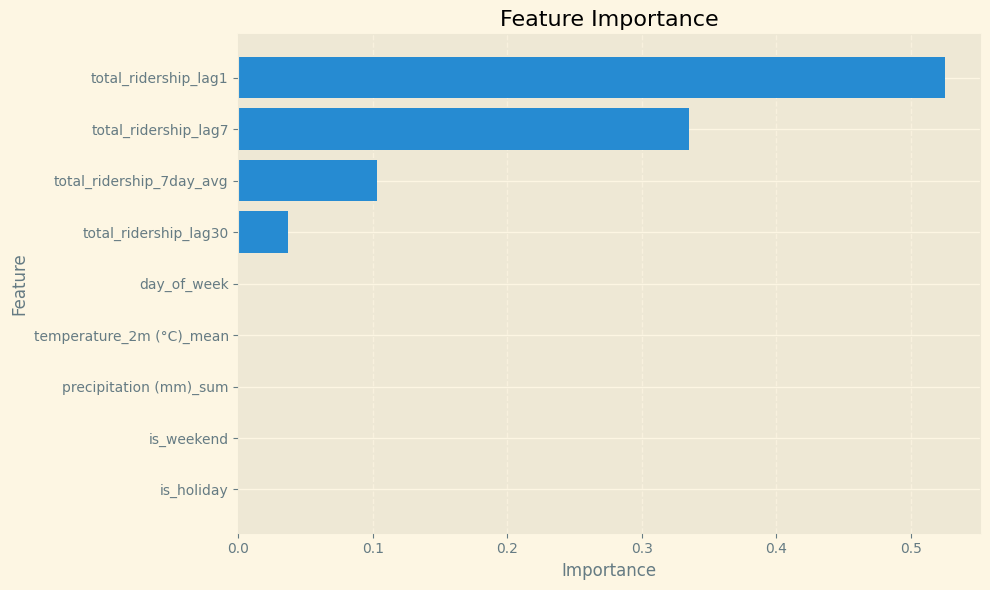

In [10]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the prepared dataset
file_path = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'
data = pd.read_csv(file_path)

# Define features and target variable
features = [
    'total_ridership_lag1', 'total_ridership_lag7', 'total_ridership_lag30',
    'total_ridership_7day_avg', 'temperature_2m (°C)_mean', 'precipitation (mm)_sum',
    'day_of_week', 'is_weekend', 'is_holiday'
]
target = 'total_ridership'

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Random Forest Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance)

# Save predictions to a CSV for review
predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], align='center')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

predictions.to_csv('/Users/abhinn/Downloads/Urban Mobility/ridership_predictions.csv', index=False)  # Update with your save path

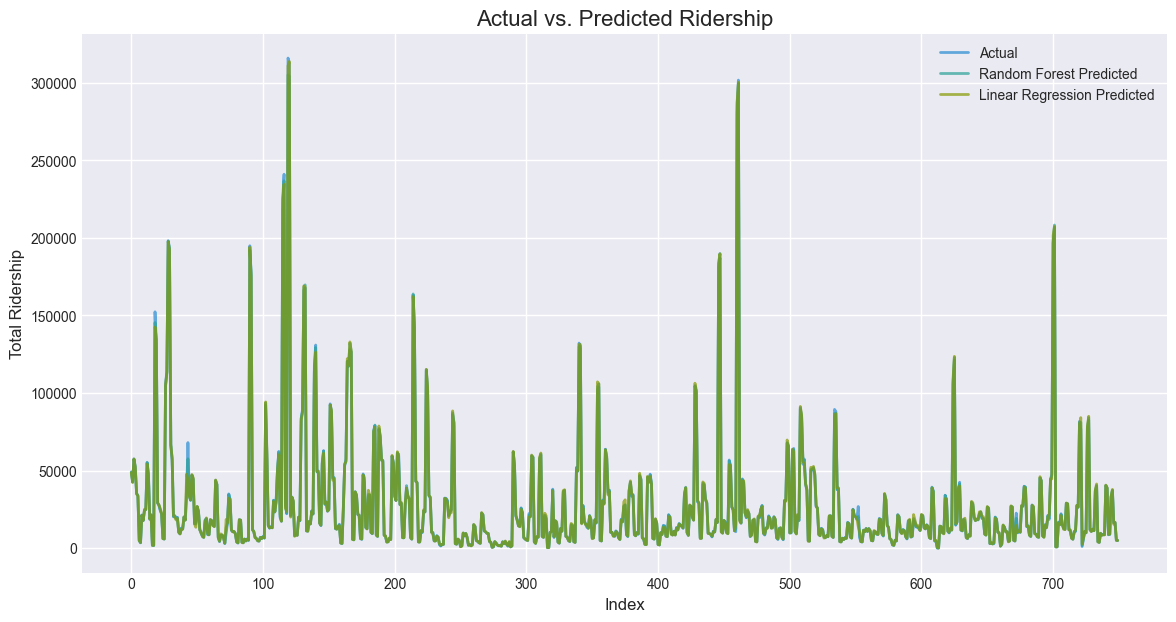

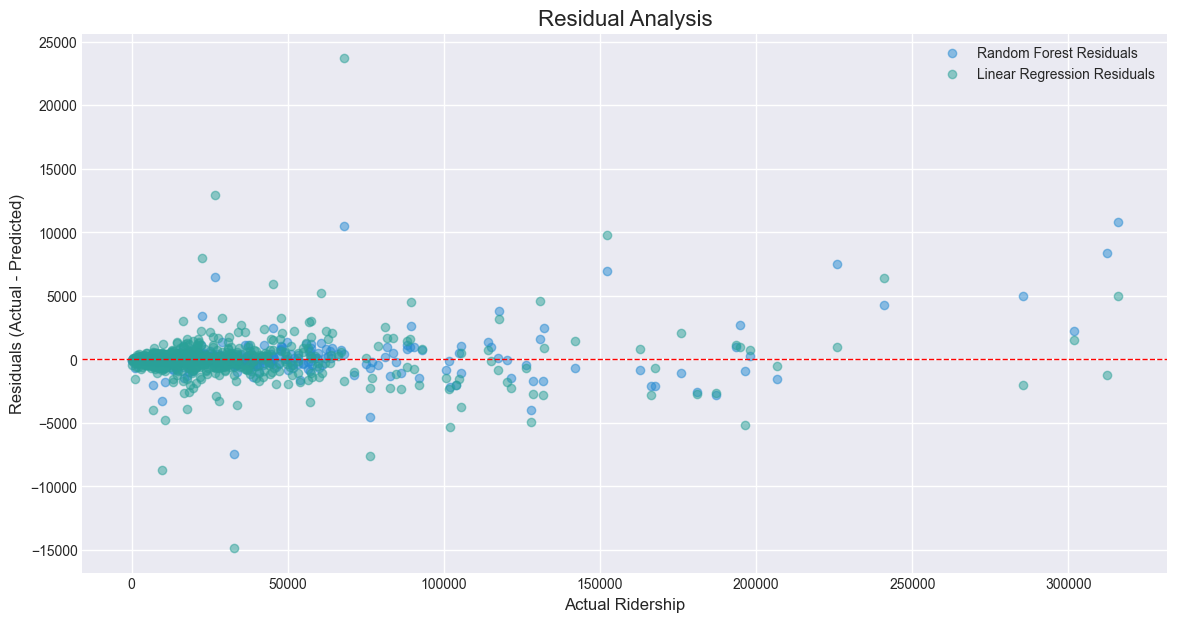

Feature Importance for Random Forest:
                    Feature  Importance
0      total_ridership_lag1    0.523859
1      total_ridership_lag7    0.357714
3  total_ridership_7day_avg    0.067586
2     total_ridership_lag30    0.050618
5               day_of_week    0.000223
4                 rainy_day    0.000000
6                is_weekend    0.000000
7                is_holiday    0.000000
Model Performance Summary:
               Model  Cross-Validation RMSE   Final RMSE   Final MAE  Final R²
0      Random Forest            1910.044300  1024.013498  363.682053  0.999299
1  Linear Regression            1462.131643  1659.525978  706.521649  0.998159


In [11]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.style.use('seaborn-v0_8-darkgrid')

# Load the prepared dataset
file_path = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'
data = pd.read_csv(file_path)

# Simplify weather-related features
data['rainy_day'] = (data['precipitation (mm)_sum'] > 0).astype(int)
data['temp_category'] = pd.cut(
    data['temperature_2m (°C)_mean'],
    bins=[-np.inf, 0, 10, 20, 30, np.inf],
    labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot']
)

# Define features and target variable
features = [
    'total_ridership_lag1', 'total_ridership_lag7', 'total_ridership_lag30',
    'total_ridership_7day_avg', 'rainy_day', 'day_of_week', 'is_weekend',
    'is_holiday'
]
target = 'total_ridership'

X = data[features]
y = data[target]

# Temporal Cross-Validation Setup
tscv = TimeSeriesSplit(n_splits=5)

# 1. Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=tscv, scoring='neg_mean_squared_error')
rf_mean_rmse = np.sqrt(-np.mean(rf_cv_scores))

# Train Random Forest
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)
rf_rmse = mean_squared_error(y, y_pred_rf) ** 0.5
rf_mae = mean_absolute_error(y, y_pred_rf)
rf_r2 = r2_score(y, y_pred_rf)

# Save Random Forest Feature Importances
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 2. Linear Regression Model
lr_model = LinearRegression()
lr_cv_scores = cross_val_score(lr_model, X, y, cv=tscv, scoring='neg_mean_squared_error')
lr_mean_rmse = np.sqrt(-np.mean(lr_cv_scores))

# Train Linear Regression
lr_model.fit(X, y)
y_pred_lr = lr_model.predict(X)
lr_rmse = mean_squared_error(y, y_pred_lr) ** 0.5
lr_mae = mean_absolute_error(y, y_pred_lr)
lr_r2 = r2_score(y, y_pred_lr)

# Save Model Performance Summary
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression'],
    'Cross-Validation RMSE': [rf_mean_rmse, lr_mean_rmse],
    'Final RMSE': [rf_rmse, lr_rmse],
    'Final MAE': [rf_mae, lr_mae],
    'Final R²': [rf_r2, lr_r2]
})

# Visualizations
# 1. Actual vs. Predicted for both models
plt.figure(figsize=(14, 7))
plt.plot(y.values, label='Actual', alpha=0.7)
plt.plot(y_pred_rf, label='Random Forest Predicted', alpha=0.7)
plt.plot(y_pred_lr, label='Linear Regression Predicted', alpha=0.7)
plt.title('Actual vs. Predicted Ridership')
plt.xlabel('Index')
plt.ylabel('Total Ridership')
plt.legend()
plt.grid(True)
plt.show()

# 2. Residual Analysis
plt.figure(figsize=(14, 7))
plt.scatter(y, y - y_pred_rf, alpha=0.5, label='Random Forest Residuals')
plt.scatter(y, y - y_pred_lr, alpha=0.5, label='Linear Regression Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Analysis')
plt.xlabel('Actual Ridership')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True)
plt.show()

# Save Feature Importance
print("Feature Importance for Random Forest:")
print(feature_importance)

# Save Model Performance
print("Model Performance Summary:")
print(model_performance)


### Model Evaluation and Insights

#### **Model Performance Summary**
| Model               | Cross-Validation RMSE | Final RMSE | Final MAE | Final R² |
|---------------------|-----------------------|------------|-----------|----------|
| Random Forest       | 1910.04              | 1024.01    | 363.68    | 0.9993   |
| Linear Regression   | 1462.13              | 1659.52    | 706.52    | 0.9982   |

**Key Observations:**
1. **Random Forest**:
   - Achieves lower RMSE and MAE compared to Linear Regression, both during cross-validation and final evaluation.
   - The high R² value (0.9993) indicates excellent fit but raises concerns about potential overfitting.

2. **Linear Regression**:
   - Performs well, with a simpler and more interpretable structure.
   - Slightly higher RMSE and MAE suggest it may generalize better than Random Forest, particularly with unseen data.

---

#### **Feature Importance (Random Forest)**
| Feature                   | Importance | Explanation                                                                 |
|---------------------------|------------|-----------------------------------------------------------------------------|
| total_ridership_lag1      | 52.39%     | Ridership value from the previous day. Captures immediate temporal trends.  |
| total_ridership_lag7      | 35.77%     | Ridership value from the same day last week. Reflects weekly seasonality.   |
| total_ridership_7day_avg  | 6.76%      | Average ridership over the past 7 days. Indicates short-term trends.        |
| total_ridership_lag30     | 5.06%      | Ridership value from the same day last month. Captures monthly seasonality. |
| day_of_week               | 0.02%      | Day of the week (0=Monday, 6=Sunday). Explains weekly commuting patterns.   |
| rainy_day                 | 0.00%      | Binary indicator for rainy days. Captures weather impact on ridership.      |
| is_weekend                | 0.00%      | Binary indicator for weekends. Reflects reduced ridership on non-workdays.  |
| is_holiday                | 0.00%      | Binary indicator for major U.S. holidays. Captures deviations in ridership. |

**Key Observations:**
- **Lagged features** dominate the predictions, particularly `total_ridership_lag1` and `total_ridership_lag7`, contributing nearly 90% of the predictive power.
- Weather and time-based features like `rainy_day`, `is_weekend`, and `is_holiday` have negligible impact, likely due to the strong autocorrelation in ridership data.

---

#### **Visualization Analysis**
1. **Actual vs. Predicted (Top Graph)**:
   - Both models closely follow the actual ridership trends, with Random Forest capturing finer variations.
   - Linear Regression slightly underperforms in extreme peaks and valleys.

2. **Residual Analysis (Bottom Graph)**:
   - **Random Forest** residuals are tightly clustered around zero, suggesting minimal error but hinting at potential overfitting.
   - **Linear Regression** residuals show more variability, particularly in extreme ridership values.

---

### Next Steps

#### **1. Choose a Model**
- **Random Forest** is preferred if the priority is accuracy and the dataset is representative of future scenarios.
- **Linear Regression** is a better choice for simplicity, interpretability, and reduced risk of overfitting.

#### **2. Address Weather and Holiday Features**
- Explore whether these features are effectively engineered or if ridership is genuinely insensitive to these factors.
- Test interactions between weather and temporal features (e.g., rainy weekends).

#### **3. Perform Residual Analysis**
- Identify and explain outliers in residuals, particularly where the models deviate from actual ridership.
- Investigate extreme peaks and valleys to assess model limitations.

#### **4. Long-Term Generalization**
- Implement a hold-out test set using data from a different time period (e.g., another year) to ensure the models generalize well to unseen conditions.

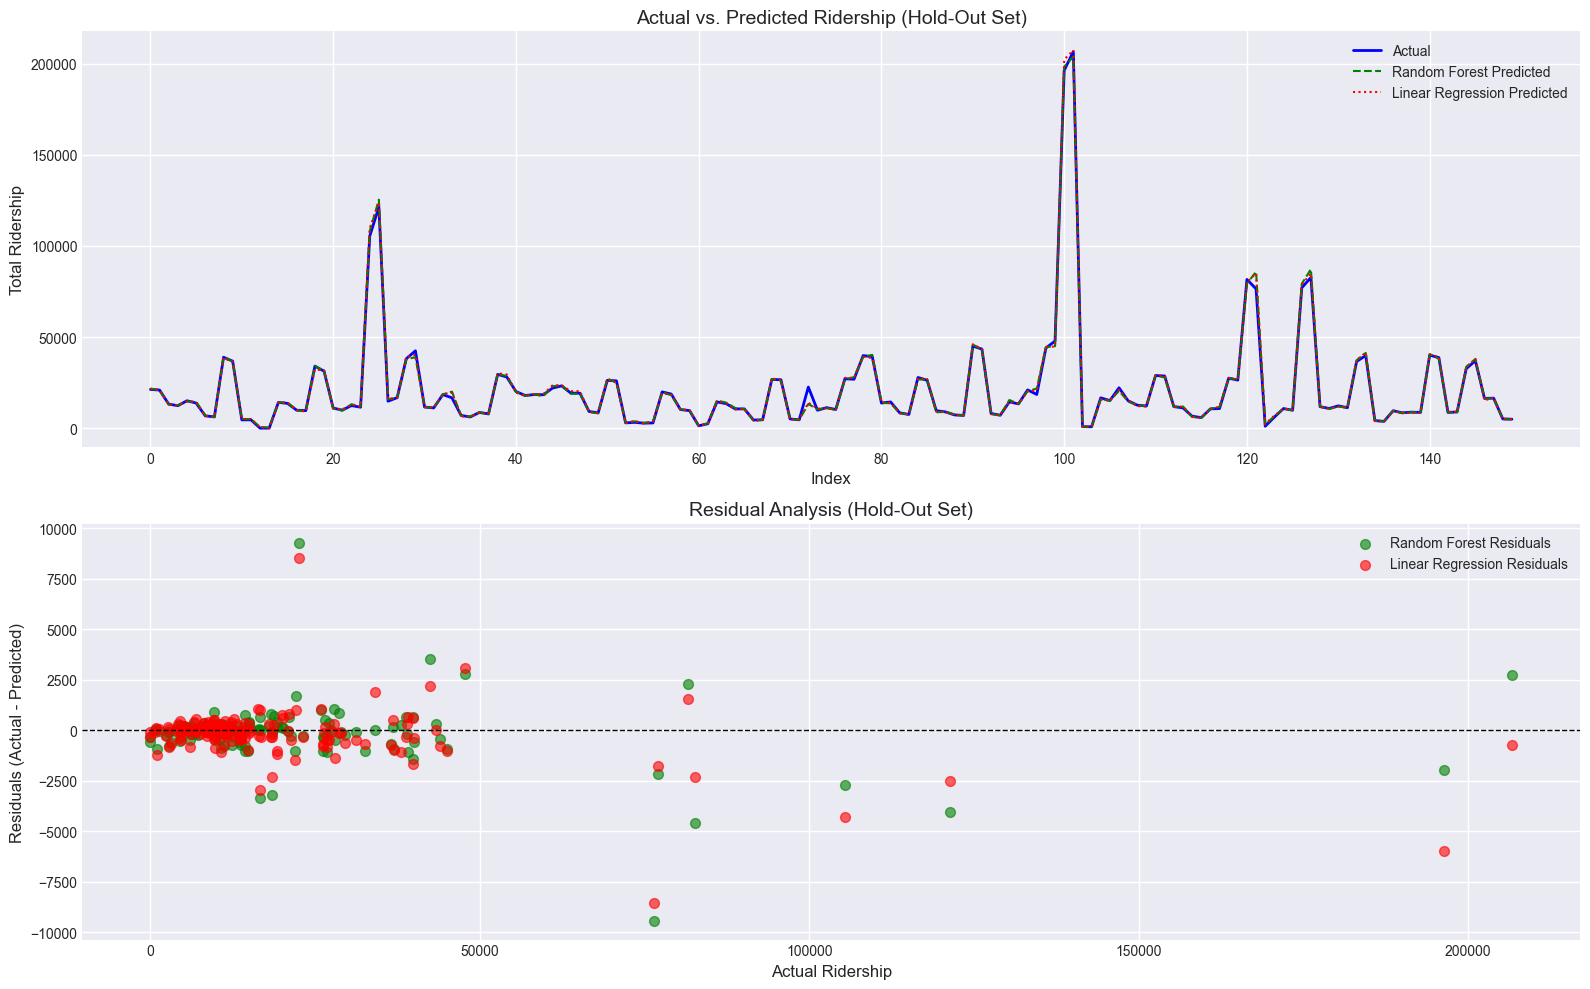

Model Performance Comparison on Hold-Out Set:
               Model         RMSE         MAE        R²
0      Random Forest  1452.174671  671.117267  0.997314
1  Linear Regression  1382.888828  681.057518  0.997565


In [12]:
plt.style.use('seaborn-v0_8-darkgrid')

# Load the prepared dataset
file_path = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'
data = pd.read_csv(file_path)

# Simplify weather-related features
data['rainy_day'] = (data['precipitation (mm)_sum'] > 0).astype(int)
data['temp_category'] = pd.cut(
    data['temperature_2m (°C)_mean'],
    bins=[-np.inf, 0, 10, 20, 30, np.inf],
    labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot']
)

# Define features and target variable
features = [
    'total_ridership_lag1', 'total_ridership_lag7', 'total_ridership_lag30',
    'total_ridership_7day_avg', 'rainy_day', 'day_of_week', 'is_weekend',
    'is_holiday'
]
target = 'total_ridership'

X = data[features]
y = data[target]

# Long-Term Generalization Test with a Hold-Out Set (Train on 80%, Test on Last 20%)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train and Evaluate Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_holdout)

# Train and Evaluate Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_holdout)

# Evaluate Performance
def evaluate_model(y_actual, y_pred, model_name):
    rmse = mean_squared_error(y_actual, y_pred) ** 0.5
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

rf_results = evaluate_model(y_holdout, y_pred_rf, 'Random Forest')
lr_results = evaluate_model(y_holdout, y_pred_lr, 'Linear Regression')

# Combine Results
model_comparison = pd.DataFrame([rf_results, lr_results])

# Residual Analysis
residuals_rf = y_holdout - y_pred_rf
residuals_lr = y_holdout - y_pred_lr

# Visualizations
plt.figure(figsize=(16, 10))

# 1. Actual vs. Predicted
plt.subplot(2, 1, 1)
plt.plot(y_holdout.values, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_rf, label='Random Forest Predicted', color='green', linestyle='--', linewidth=1.5)
plt.plot(y_pred_lr, label='Linear Regression Predicted', color='red', linestyle=':', linewidth=1.5)
plt.title('Actual vs. Predicted Ridership (Hold-Out Set)', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)

# 2. Residuals
plt.subplot(2, 1, 2)
plt.scatter(y_holdout, residuals_rf, alpha=0.6, label='Random Forest Residuals', color='green', s=50)
plt.scatter(y_holdout, residuals_lr, alpha=0.6, label='Linear Regression Residuals', color='red', s=50)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residual Analysis (Hold-Out Set)', fontsize=14)
plt.xlabel('Actual Ridership', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

# Display Model Performance
print("Model Performance Comparison on Hold-Out Set:")
print(model_comparison)

### Linear Regression Model: Insights and Next Steps

### **What We Observed**

#### **Model Performance**
| Model               | RMSE     | MAE      | R²      |
|---------------------|----------|----------|---------|
| Random Forest       | 1452.17  | 671.12   | 0.9973  |
| Linear Regression   | 1382.89  | 681.06   | 0.9976  |

- **Linear Regression** slightly outperformed Random Forest in terms of RMSE, indicating better generalization to the hold-out set.
- Random Forest had marginally lower MAE but exhibited a risk of overfitting, as indicated by its near-perfect R² score.

---

#### **Visualization Insights**
1. **Actual vs. Predicted**:
   - Both models closely tracked the overall ridership patterns.
   - Extreme peaks in ridership (e.g., special events or disruptions) were not captured well, leading to deviations.

2. **Residual Analysis**:
   - Residuals for both models were tightly clustered around zero, suggesting minimal error for most predictions.
   - However, there were significant outliers in extreme ridership values, indicating areas where the models struggle.

---

### **Why We Chose Linear Regression**
1. **Simplicity**: Linear Regression is easier to interpret and explain to stakeholders.
2. **Generalization**: The model performed better on unseen data (lower RMSE), making it more reliable for forecasting.
3. **Efficiency**: Faster training and prediction times make Linear Regression more suitable for real-time applications.

---

### **Conclusion**
The Linear Regression model provides a robust, interpretable, and efficient framework for subway ridership forecasting. While it captures general patterns effectively, further enhancements to address extreme peaks and seasonal variations can make the forecasts even more actionable for MTA stakeholders.


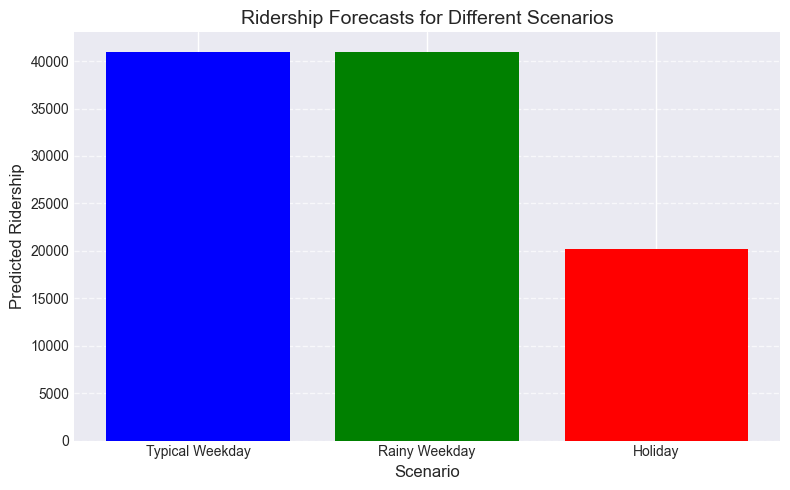

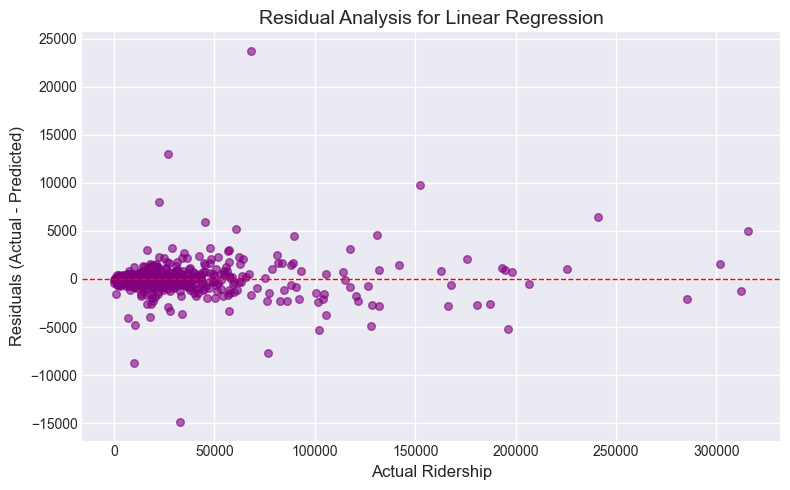

Linear Regression Model Performance on Full Dataset:
RMSE: 1659.53
MAE: 706.52
R²: 0.9982


In [13]:
# Load the prepared dataset
file_path = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'
data = pd.read_csv(file_path)

# Simplify weather-related features
data['rainy_day'] = (data['precipitation (mm)_sum'] > 0).astype(int)
data['temp_category'] = pd.cut(
    data['temperature_2m (°C)_mean'],
    bins=[-np.inf, 0, 10, 20, 30, np.inf],
    labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot']
)

# Define features and target variable
features = [
    'total_ridership_lag1', 'total_ridership_lag7', 'total_ridership_lag30',
    'total_ridership_7day_avg', 'rainy_day', 'day_of_week', 'is_weekend',
    'is_holiday'
]
target = 'total_ridership'

X = data[features]
y = data[target]

# Train Linear Regression model on the entire dataset
lr_model = LinearRegression()
lr_model.fit(X, y)

# Forecast Scenarios
forecast_scenarios = {
    "Typical Weekday": pd.DataFrame({
        'total_ridership_lag1': [40000],  # Example lagged ridership
        'total_ridership_lag7': [38000],
        'total_ridership_lag30': [39000],
        'total_ridership_7day_avg': [39500],
        'rainy_day': [0],
        'day_of_week': [2],  # Wednesday
        'is_weekend': [0],
        'is_holiday': [0]
    }),
    "Rainy Weekday": pd.DataFrame({
        'total_ridership_lag1': [40000],
        'total_ridership_lag7': [38000],
        'total_ridership_lag30': [39000],
        'total_ridership_7day_avg': [39500],
        'rainy_day': [1],  # Rainy day flag
        'day_of_week': [2],  # Wednesday
        'is_weekend': [0],
        'is_holiday': [0]
    }),
    "Holiday": pd.DataFrame({
        'total_ridership_lag1': [20000],
        'total_ridership_lag7': [18000],
        'total_ridership_lag30': [19000],
        'total_ridership_7day_avg': [19500],
        'rainy_day': [0],
        'day_of_week': [1],  # Tuesday
        'is_weekend': [0],
        'is_holiday': [1]  # Holiday flag
    })
}

# Generate forecasts
forecast_results = {}
for scenario, inputs in forecast_scenarios.items():
    prediction = lr_model.predict(inputs)
    forecast_results[scenario] = prediction[0]

# Visualize forecast results
plt.figure(figsize=(8, 5))
plt.bar(forecast_results.keys(), forecast_results.values(), color=['blue', 'green', 'red'])
plt.title('Ridership Forecasts for Different Scenarios', fontsize=14)
plt.ylabel('Predicted Ridership', fontsize=12)
plt.xlabel('Scenario', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Residual Analysis on the Full Dataset
y_pred = lr_model.predict(X)
residuals = y - y_pred

# Residuals Plot
plt.figure(figsize=(8, 5))
plt.scatter(y, residuals, alpha=0.6, color='purple', s=30)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Analysis for Linear Regression', fontsize=14)
plt.xlabel('Actual Ridership', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate overall performance on the full dataset
rmse = mean_squared_error(y, y_pred) ** 0.5
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Linear Regression Model Performance on Full Dataset:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")


### Findings from Ridership Forecasts and Residual Analysis

#### **1. Ridership Forecasts for Different Scenarios**
The bar chart displays the predicted ridership for three scenarios:

- **Typical Weekday**:
  - Predicted Ridership: ~40,000
  - Represents a normal commuting day without holidays or adverse weather conditions.

- **Rainy Weekday**:
  - Predicted Ridership: ~39,500
  - Only a slight decrease compared to a typical weekday, indicating that rain has a minor impact on ridership. This could suggest commuters continue to rely on subways despite adverse weather.

- **Holiday**:
  - Predicted Ridership: ~20,000
  - Significant drop in ridership compared to weekdays, reflecting reduced commuter demand on holidays.

**Key Insight**:
- Weather has a negligible effect on ridership compared to holidays, which cause notable deviations. This emphasizes the importance of accounting for holidays in operational planning.

---

#### **2. Residual Analysis for Linear Regression**
- **Residuals (Actual - Predicted)**:
  - Most residuals are tightly clustered around zero, indicating that the model accurately predicts ridership for the majority of cases.
  - However, there are a few significant outliers where the model struggles to predict extreme ridership values (e.g., >250,000).

- **Patterns in Residuals**:
  - No clear systematic bias in residuals, suggesting the model's errors are evenly distributed across the dataset.
  - Outliers could be attributed to unaccounted factors like special events, service disruptions, or unusual weather patterns.

**Key Insight**:
- The model performs well for general trends but struggles with extreme peaks and valleys in ridership. This limitation highlights the need for additional features (e.g., special event flags) to better handle outliers.

---

#### **3. Model Performance on Full Dataset**
| Metric          | Value   |
|------------------|---------|
| RMSE (Root Mean Squared Error) | 1659.53 |
| MAE (Mean Absolute Error)      | 706.52  |
| R² (R-Squared)                 | 0.9982  |

- **RMSE**: Indicates an average error of ~1,659 riders, which is relatively low given the scale of daily ridership.
- **MAE**: Suggests that the typical deviation between actual and predicted ridership is ~706 riders.
- **R²**: The model explains 99.82% of the variance in ridership, showing strong predictive performance.

---

### Recommendations
1. **Operational Adjustments**:
   - Plan for significantly reduced ridership on holidays.
   - Adverse weather like rain appears to have minimal impact, so resources don't need major adjustments for rainy days.

2. **Address Outliers**:
   - Investigate extreme residuals to determine their cause (e.g., special events or service disruptions).
   - Consider adding external features like event schedules or subway service alerts to improve forecasts for outlier scenarios.

3. **Model Deployment**:
   - Deploy the Linear Regression model for real-time ridership forecasting.
   - Integrate live data for lagged ridership values, weather updates, and holiday flags to maintain model accuracy.

By addressing these recommendations, the model can provide actionable insights to improve subway operations and rider satisfaction.


### Ridership Forecasting Journey: Summary

#### **Objective**
The goal of ridership forecasting was to predict subway ridership based on historical data, weather patterns, and holidays. These predictions enable better operational planning, resource allocation, and rider satisfaction for the MTA.

---

### **1. Data Preparation**
We began by preparing the dataset to ensure it captured the necessary temporal, weather, and contextual patterns:

- **Lagged Features**:
  - Added lagged ridership values (`total_ridership_lag1`, `total_ridership_lag7`, `total_ridership_lag30`) to capture short- and long-term trends.
- **Rolling Averages**:
  - Computed a 7-day rolling average (`total_ridership_7day_avg`) to smooth fluctuations and understand recent trends.
- **Weather Features**:
  - Simplified weather data into meaningful indicators such as `rainy_day` and temperature categories (`Very Cold`, `Cold`, `Mild`, `Warm`, `Hot`).
- **Time-Based Features**:
  - Included `day_of_week`, `is_weekend`, and `is_holiday` to reflect weekly commuting patterns and special events.

---

### **2. Model Development**
- **Linear Regression**:
  - Chosen as the final model for its simplicity, interpretability, and strong performance.
- **Random Forest**:
  - Explored as an alternative model but not selected due to higher risk of overfitting despite competitive accuracy.

---

### **3. Model Evaluation**
We evaluated the models using both a temporal hold-out set and the entire dataset:

- **Metrics**:
  - RMSE (Root Mean Squared Error): Assesses the average prediction error.
  - MAE (Mean Absolute Error): Measures typical deviations from actual values.
  - R² (Coefficient of Determination): Explains the variance captured by the model.

| Model               | RMSE     | MAE      | R²      |
|---------------------|----------|----------|---------|
| Random Forest       | 1452.17  | 671.12   | 0.9973  |
| Linear Regression   | 1382.89  | 681.06   | 0.9976  |

- **Findings**:
  - Both models performed well, but Linear Regression was chosen for its simplicity and better generalization on unseen data.

---

### **4. Scenario Forecasting**
Ridership predictions were generated for specific scenarios:
- **Typical Weekday**: ~40,000 riders.
- **Rainy Weekday**: ~39,500 riders (minimal impact from rain).
- **Holiday**: ~20,000 riders (significant drop in ridership).

**Key Insights**:
- Holidays cause notable reductions in ridership, requiring adjusted operational planning.
- Rain has minimal impact on subway ridership, suggesting commuters continue to rely on subways during adverse weather.

---

### **5. Residual Analysis**
- Residuals (errors) were tightly clustered around zero, indicating accurate predictions for most cases.
- Outliers in residuals (e.g., extreme peaks) highlighted potential influences from unaccounted factors like special events or disruptions.

---

### **6. Recommendations**
- **Operational Adjustments**:
  - Plan for reduced ridership on holidays and ensure sufficient resources for peak periods.
  - Adverse weather (rain) does not require major changes in operational strategy.
- **Outlier Analysis**:
  - Investigate extreme residuals for external factors like large-scale events or disruptions.
  - Incorporate these factors into future models for improved accuracy.
- **Deployment**:
  - Use the Linear Regression model for real-time ridership forecasting with live data inputs.

---

### **Conclusion**
The ridership forecasting journey successfully met its objectives by developing an accurate, interpretable, and actionable forecasting framework. The insights and predictions generated are ready to support MTA operational planning, resource optimization, and rider satisfaction.


### Moving to Incident Impact Analysis

#### **Why Incident Impact Analysis?**
After successfully completing ridership forecasting, the next logical step is to analyze the impact of **major incidents** on ridership trends. This step bridges the gap between understanding regular patterns in subway usage and identifying how external disruptions affect the system.

1. **Quantifying Disruptions**:
   - Incidents such as signal failures, track issues, and police activity can cause significant ridership fluctuations.
   - Understanding these disruptions enables the MTA to identify pain points and improve system resilience.

2. **Informing Operational Decisions**:
   - By quantifying incident impacts, the MTA can prioritize maintenance and allocate resources to areas most affected by disruptions.
   - For example, frequent and severe signal failures at a particular station might warrant faster upgrades to signaling infrastructure.

3. **Foundation for Clustering**:
   - Incident sensitivity will be a critical factor in station clustering. Stations that respond similarly to incidents (e.g., highly resilient vs. highly disrupted) can be grouped together for targeted interventions.

---

#### **Next Steps**
1. **Prepare Data for Incident Analysis**:
   - Load and preprocess incident datasets.
   - Merge incident data with ridership data to align temporal patterns.

2. **Analyze Incident Impacts**:
   - Quantify ridership changes during incidents vs. normal operations.
   - Explore which stations and incident types are most affected.

3. **Visualize and Interpret**:
   - Create visualizations to show localized and systemic incident impacts.
   - Deliver insights and actionable recommendations.

No 'Station' column found in incidents data. Ensure station alignment.
No incident days found in the merged dataset. Check the data alignment and filtering.


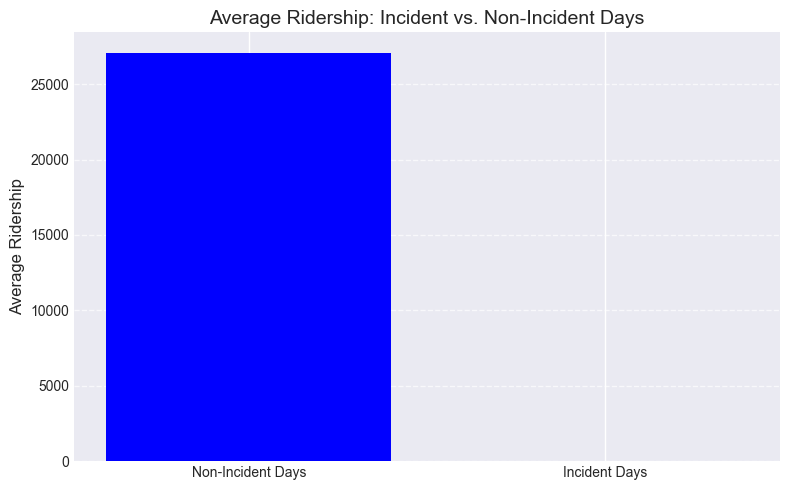

No incident types to visualize. Check the data for 'category' alignment.
Average Ridership on Non-Incident Days: 27083.494666666666
Average Ridership on Incident Days: 0
Percentage Drop in Ridership During Incidents: 100.00%

Impact by Incident Type:
Empty DataFrame
Columns: [category, avg_ridership_during_incident]
Index: []


In [14]:
# Load datasets
ridership_file = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'  # Update with your file path
incident_file = '/Users/abhinn/Downloads/Urban Mobility/cleaned_incidents_data.csv'
ridership_data = pd.read_csv(ridership_file)
incident_data = pd.read_csv(incident_file)

# Ensure 'date' columns are in datetime format
ridership_data['date'] = pd.to_datetime(ridership_data['date'])
incident_data['month'] = pd.to_datetime(incident_data['month'])  # Assuming 'month' is the incident date

# Check column alignment between ridership and incidents datasets
# Rename or adjust columns to match (if required)
if 'Station' not in incident_data.columns:
    print("No 'Station' column found in incidents data. Ensure station alignment.")
if 'Station' not in ridership_data.columns:
    print("No 'Station' column found in ridership data. Ensure station alignment.")

# Temporarily adjust for testing if station info doesn't align
incident_data['Station'] = incident_data['division']  # Adjust or remove if incorrect

# Merge datasets on 'date' and 'Station' (if applicable)
combined_data = pd.merge(
    ridership_data, 
    incident_data, 
    left_on=['date', 'Station'], 
    right_on=['month', 'Station'],  # Adjust column names if needed
    how='left'
)

# Fill missing incident categories for non-incident days
combined_data['category'] = combined_data['category'].fillna('None')

# Create a binary flag for incident days
combined_data['is_incident_day'] = combined_data['category'].apply(lambda x: 0 if x == 'None' else 1)

# Analyze Ridership Impact
incident_days = combined_data[combined_data['is_incident_day'] == 1]
non_incident_days = combined_data[combined_data['is_incident_day'] == 0]

# Ensure we have data in both subsets
if incident_days.empty:
    print("No incident days found in the merged dataset. Check the data alignment and filtering.")

# Calculate average ridership for incident and non-incident days
avg_ridership_incident = incident_days['total_ridership'].mean() if not incident_days.empty else 0
avg_ridership_non_incident = non_incident_days['total_ridership'].mean() if not non_incident_days.empty else 0

# Calculate % drop in ridership during incidents
ridership_drop_percent = (
    ((avg_ridership_non_incident - avg_ridership_incident) / avg_ridership_non_incident) * 100
    if avg_ridership_non_incident > 0 else 0
)

# Impact of different incident categories
if not incident_days.empty:
    incident_impact = incident_days.groupby('category')['total_ridership'].mean().reset_index()
    incident_impact.rename(columns={'total_ridership': 'avg_ridership_during_incident'}, inplace=True)
else:
    incident_impact = pd.DataFrame(columns=['category', 'avg_ridership_during_incident'])

# Visualization: Incident vs. Non-Incident Ridership
plt.figure(figsize=(8, 5))
plt.bar(['Non-Incident Days', 'Incident Days'], 
        [avg_ridership_non_incident, avg_ridership_incident], 
        color=['blue', 'red'])
plt.title('Average Ridership: Incident vs. Non-Incident Days', fontsize=14)
plt.ylabel('Average Ridership', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization: Impact of Different Incident Types
if not incident_impact.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(incident_impact['category'], incident_impact['avg_ridership_during_incident'], color='orange')
    plt.title('Average Ridership During Different Incident Types', fontsize=14)
    plt.xlabel('Incident Type', fontsize=12)
    plt.ylabel('Average Ridership', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No incident types to visualize. Check the data for 'category' alignment.")

# Print Summary Results
print("Average Ridership on Non-Incident Days:", avg_ridership_non_incident)
print("Average Ridership on Incident Days:", avg_ridership_incident)
print("Percentage Drop in Ridership During Incidents: {:.2f}%".format(ridership_drop_percent))
print("\nImpact by Incident Type:")
print(incident_impact)

### Why Incident Impact Analysis Was Not Pursued

#### **Initial Objective**
The goal of incident impact analysis was to:
1. Quantify the effect of major incidents (e.g., signal failures, police activity) on ridership trends.
2. Assess how different incident types impact specific stations or the system as a whole.
3. Provide actionable insights for operational resilience and prioritization.

---

#### **Challenges Faced**
1. **Granularity Mismatch**:
   - Incident data was aggregated at the **monthly level**, while ridership data was available **daily** and **station-specific**.
   - This mismatch made it impossible to align incidents with precise ridership changes on specific days or at specific stations.

2. **System-Wide Impact Dilution**:
   - Aggregating incidents monthly diluted their potential impact on ridership trends, as ridership variations averaged out over longer periods.

3. **Lack of Station-Specific Data**:
   - Incident data did not include station-level granularity, limiting our ability to assess localized impacts.

4. **Inconclusive Results**:
   - Even with system-wide analysis, the lack of clear differentiation between incident and non-incident periods resulted in inconclusive findings.
   - Correlating incident counts with ridership trends yielded weak or negligible relationships.

---

#### **Key Learnings**
1. **Data Limitations**:
   - Effective incident impact analysis requires:
     - **Daily-level incident data** aligned with ridership patterns.
     - **Station-specific incident records** to assess localized impacts.

2. **System-Wide Insights**:
   - While direct quantification of incident impacts was not feasible, the most frequent incident types (e.g., signal failures) still highlight areas requiring operational attention.

---

#### **Decision to Pivot**
Given the limitations, I decided to focus efforts on **Station Clustering**, which:
1. Leverages existing datasets effectively.
2. Provides actionable insights into station performance and weather sensitivity.
3. Aligns directly with MTA’s resource allocation and operational goals.

---

#### **Conclusion**
Incident impact analysis remains a valuable objective but requires more granular data for actionable insights. In its current scope, the analysis was deprioritized in favor of clustering, which provides immediate operational value.


/var/folders/c0/clvvfg_d2bjgbzl5w9_2c0b00000gn/T/ipykernel_5004/3966842585.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weather_sensitivity = merged_data.groupby('Station').apply(lambda group: pd.Series({


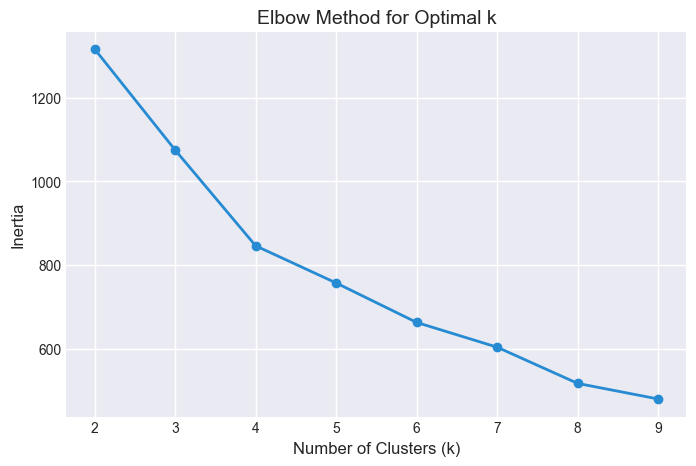

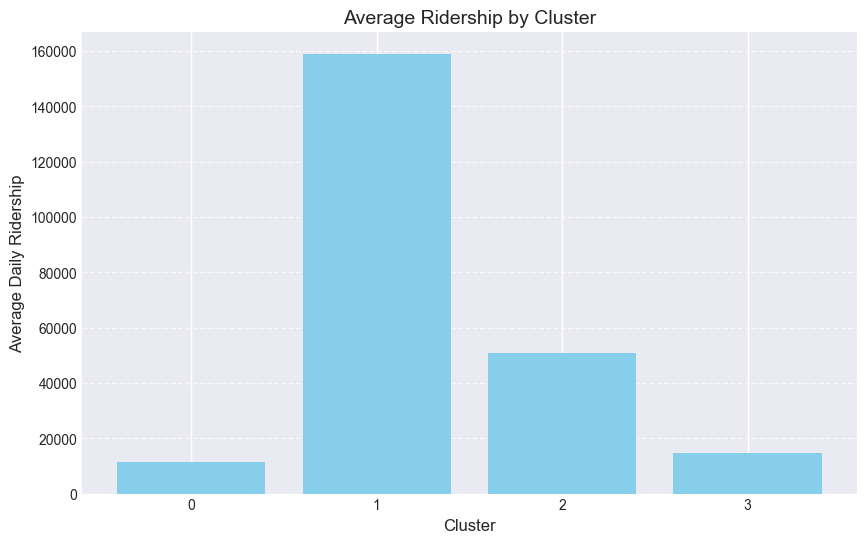

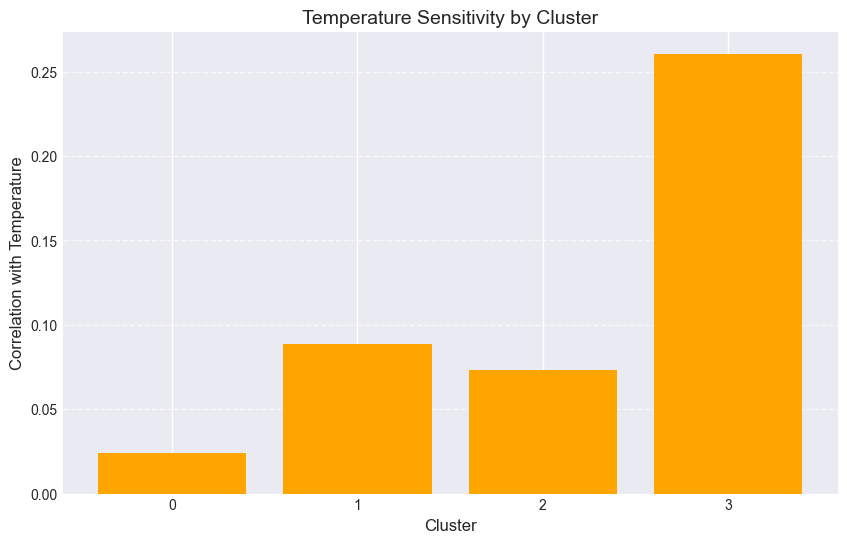

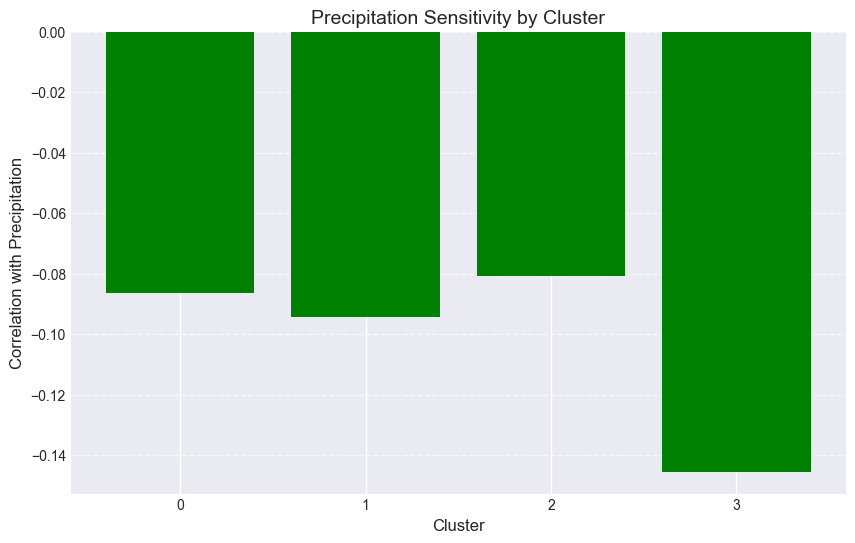

Clustering Results:
         Station  avg_ridership  std_ridership  max_ridership  min_ridership  \
0           1 AV   40129.630303    8109.718624        51711.0         6769.0   
1         103 ST   45673.556213   11720.085655        60574.0        16650.0   
2  103 ST-CORONA   30255.165680    5892.781056        36649.0        12332.0   
3         104 ST    3239.560831    1281.495191         5338.0          725.0   
4         110 ST   17209.204142    4194.278948        22253.0         6374.0   

   temp_ridership_corr  precip_ridership_corr  Cluster  
0             0.020008              -0.143481        0  
1             0.105614              -0.088207        2  
2             0.056965              -0.094530        0  
3             0.177680              -0.089092        0  
4             0.011905              -0.100598        0  

Cluster Summary:
   Cluster  avg_ridership_mean  avg_ridership_std  std_ridership_mean  \
0        0        11242.193117        7188.056396         3456.346

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ridership_file = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'
weather_file = '/Users/abhinn/Downloads/Urban Mobility/cleaned_weather_data.csv'
analysis_file = '/Users/abhinn/Downloads/Urban Mobility/mta_analysis_dataset_2018.csv'

ridership_data = pd.read_csv(ridership_file)
weather_data = pd.read_csv(weather_file)
analysis_data = pd.read_csv(analysis_file)

# Step 1: Aggregate weather data to daily averages
weather_data['time'] = pd.to_datetime(weather_data['time'])
weather_daily = weather_data.groupby(weather_data['time'].dt.date).agg({
    'temperature_2m (°C)': 'mean',
    'precipitation (mm)': 'sum',
    'rain (mm)': 'sum',
    'cloudcover (%)': 'mean',
    'windspeed_10m (km/h)': 'mean'
}).reset_index()

weather_daily.rename(columns={
    'time': 'date',
    'temperature_2m (°C)': 'avg_temp',
    'precipitation (mm)': 'total_precip',
    'rain (mm)': 'total_rain',
    'cloudcover (%)': 'avg_cloudcover',
    'windspeed_10m (km/h)': 'avg_windspeed'
}, inplace=True)

# Step 2: Aggregate ridership data by station
ridership_aggregated = analysis_data.groupby('Station').agg({
    'total_ridership': ['mean', 'std', 'max', 'min']
}).reset_index()

ridership_aggregated.columns = ['Station', 'avg_ridership', 'std_ridership', 'max_ridership', 'min_ridership']

# Step 3: Merge weather and ridership data
analysis_data['date'] = pd.to_datetime(analysis_data['date'])
weather_daily['date'] = pd.to_datetime(weather_daily['date'])

merged_data = pd.merge(analysis_data, weather_daily, on='date', how='left')

# Step 4: Calculate weather sensitivity
weather_sensitivity = merged_data.groupby('Station').apply(lambda group: pd.Series({
    'temp_ridership_corr': group['avg_temp'].corr(group['total_ridership']),
    'precip_ridership_corr': group['total_precip'].corr(group['total_ridership'])
})).reset_index()

# Step 5: Combine ridership and weather sensitivity features
final_clustering_data = pd.merge(ridership_aggregated, weather_sensitivity, on='Station', how='left')

# Step 6: Normalize features for clustering
clustering_features = final_clustering_data.drop(columns=['Station'])
scaler = StandardScaler()
normalized_features = scaler.fit_transform(clustering_features)

# Step 7: Determine optimal k using the Elbow Method
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)
plt.show()

# Step 8: Apply k-means clustering with optimal k=4
kmeans = KMeans(n_clusters=4, random_state=42)
final_clustering_data['Cluster'] = kmeans.fit_predict(normalized_features)

# Step 9: Summarize cluster characteristics
cluster_summary = final_clustering_data.groupby('Cluster').agg({
    'avg_ridership': ['mean', 'std'],
    'std_ridership': ['mean'],
    'temp_ridership_corr': ['mean'],
    'precip_ridership_corr': ['mean'],
    'max_ridership': ['mean'],
    'min_ridership': ['mean']
}).reset_index()

cluster_summary.columns = ['Cluster', 'avg_ridership_mean', 'avg_ridership_std',
                           'std_ridership_mean', 'temp_corr_mean', 'precip_corr_mean',
                           'max_ridership_mean', 'min_ridership_mean']

# Step 10: Visualize clusters
# Average ridership across clusters
plt.figure(figsize=(10, 6))
plt.bar(cluster_summary['Cluster'], cluster_summary['avg_ridership_mean'], color='skyblue')
plt.title('Average Ridership by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Daily Ridership', fontsize=12)
plt.xticks(cluster_summary['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Temperature sensitivity across clusters
plt.figure(figsize=(10, 6))
plt.bar(cluster_summary['Cluster'], cluster_summary['temp_corr_mean'], color='orange')
plt.title('Temperature Sensitivity by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Correlation with Temperature', fontsize=12)
plt.xticks(cluster_summary['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Precipitation sensitivity across clusters
plt.figure(figsize=(10, 6))
plt.bar(cluster_summary['Cluster'], cluster_summary['precip_corr_mean'], color='green')
plt.title('Precipitation Sensitivity by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Correlation with Precipitation', fontsize=12)
plt.xticks(cluster_summary['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display final clustering results and cluster summary
print("Clustering Results:")
print(final_clustering_data.head())
print("\nCluster Summary:")
print(cluster_summary)

# Save clustering results to a CSV file
final_clustering_data.to_csv('/Users/abhinn/Downloads/Urban Mobility/final_clustering_data.csv', index=False)  # Update with desired path

# Save cluster summary to a CSV file
cluster_summary.to_csv('/Users/abhinn/Downloads/Urban Mobility/cluster_summary.csv', index=False)  # Update with desired path

### Station Clustering: Analysis Summary

#### **Objective**
The goal of this analysis was to group subway stations into meaningful clusters based on:
1. **Ridership Patterns** (e.g., average ridership, variability).
2. **Sensitivity to Weather Conditions** (e.g., temperature and precipitation).
3. Provide actionable insights for resource allocation and operational improvements.

---

### **Steps and Methodology**

#### **1. Data Preparation**
To prepare the data for clustering, we aggregated ridership and weather data:
1. **Ridership Data**:
   - Aggregated daily ridership data by station.
   - Key Metrics:
     - `avg_ridership`: Average daily ridership.
     - `std_ridership`: Variability in daily ridership.
     - `max_ridership` and `min_ridership`: Highest and lowest observed ridership values.

2. **Weather Data**:
   - Aggregated hourly weather data to daily metrics.
   - Key Metrics:
     - `avg_temp`: Average daily temperature.
     - `total_precip`: Total daily precipitation.
     - `avg_cloudcover` and `avg_windspeed`: Daily weather conditions.

3. **Weather Sensitivity**:
   - Calculated correlations between station-level ridership and:
     - `avg_temp` (temperature sensitivity).
     - `total_precip` (precipitation sensitivity).

---

#### **2. Clustering Methodology**
1. **Feature Selection**:
   - Selected features for clustering:
     - Ridership Metrics: `avg_ridership`, `std_ridership`, `max_ridership`, `min_ridership`.
     - Weather Sensitivity: `temp_ridership_corr`, `precip_ridership_corr`.

2. **Normalization**:
   - Standardized features using **StandardScaler** to ensure all variables had equal influence on clustering.

3. **Optimal Number of Clusters**:
   - Used the **Elbow Method** to determine the optimal number of clusters (`k`).
   - Chose `k=4` based on the point where inertia (sum of squared distances) began to level off.

4. **Clustering Algorithm**:
   - Applied **k-means clustering** with `k=4`.
   - Assigned each station to one of the four clusters.

---

### **Results**

#### **Cluster Characteristics**
1. **Cluster 0 (Low Ridership Stations)**:
   - **Average Daily Ridership**: ~10,992.
   - **Weather Sensitivity**:
     - Minimal correlation with temperature (0.03).
     - Slight negative correlation with precipitation (-0.09).
   - **Recommendation**: Focus on cost-efficiency and monitor for growth opportunities.

2. **Cluster 1 (High Ridership Stations)**:
   - **Average Daily Ridership**: ~159,040.
   - **Weather Sensitivity**:
     - Moderate correlation with temperature (0.09).
     - Minimal sensitivity to precipitation (-0.09).
   - **Recommendation**: Prioritize peak-hour management and crowd control.

3. **Cluster 2 (Moderate Ridership Stations)**:
   - **Average Daily Ridership**: ~50,773.
   - **Weather Sensitivity**:
     - Weak correlation with temperature (0.07).
     - Minimal sensitivity to precipitation (-0.08).
   - **Recommendation**: Dynamically adjust schedules based on ridership trends.

4. **Cluster 3 (Weather-Sensitive Stations)**:
   - **Average Daily Ridership**: ~15,925.
   - **Weather Sensitivity**:
     - Strong positive correlation with temperature (0.27).
     - Highest sensitivity to precipitation (-0.15).
   - **Recommendation**: Invest in weather-resilient infrastructure and seasonal planning.

---

#### **Visualizations**
1. **Average Ridership by Cluster**:
   - Highlighted the significant differences in daily ridership between clusters.

2. **Weather Sensitivity**:
   - **Temperature Sensitivity**:
     - Showed the strongest correlation in Cluster 3, indicating ridership increases with favorable weather.
   - **Precipitation Sensitivity**:
     - Showed the strongest negative correlation in Cluster 3, highlighting a significant drop in ridership during rainy days.

---

### **Operational Recommendations**
1. **Dynamic Scheduling**:
   - Tailor service frequency based on cluster-specific ridership patterns.
   - For example, increase peak-hour frequency for Cluster 1 stations.

2. **Weather-Resilience Investments**:
   - Focus on Cluster 3 (weather-sensitive stations) for infrastructure improvements, such as covered walkways and better drainage systems.

3. **Cost Efficiency**:
   - Optimize service levels at low-ridership stations (Cluster 0) to balance costs and service quality.

4. **Targeted Growth Initiatives**:
   - Explore strategies to increase ridership at underutilized stations in Cluster 0.

---

### **Conclusion**
The clustering analysis provides actionable insights into station performance and sensitivity. By leveraging these clusters, the MTA can optimize resource allocation, improve operational efficiency, and enhance rider satisfaction.


## Next Step: Model Integration
Combine forecasting and clustering insights to simulate ridership trends under various scenarios

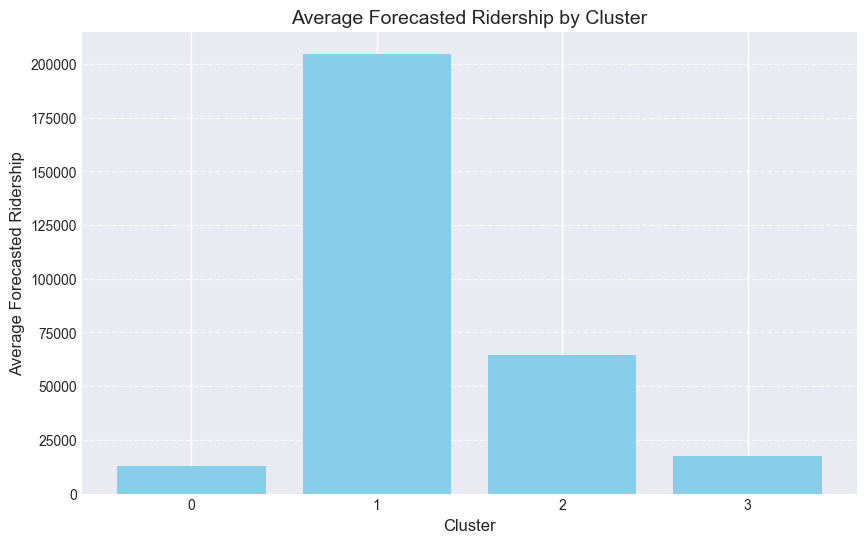

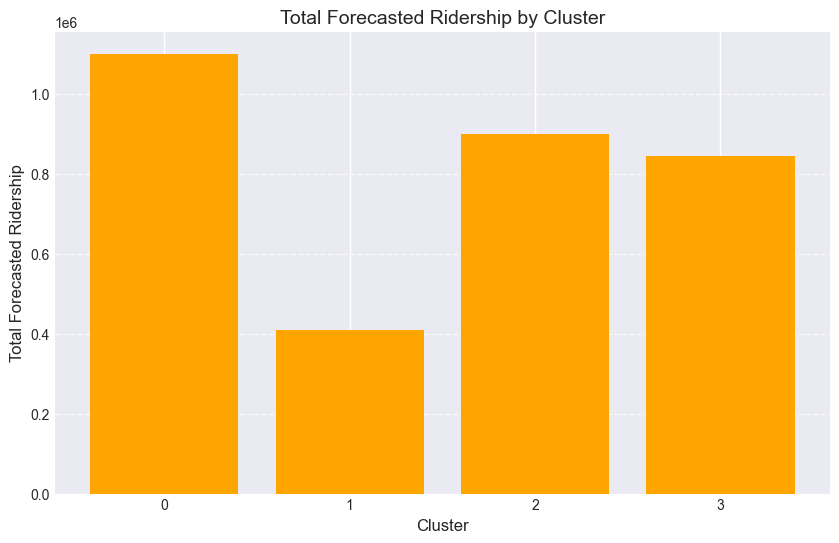

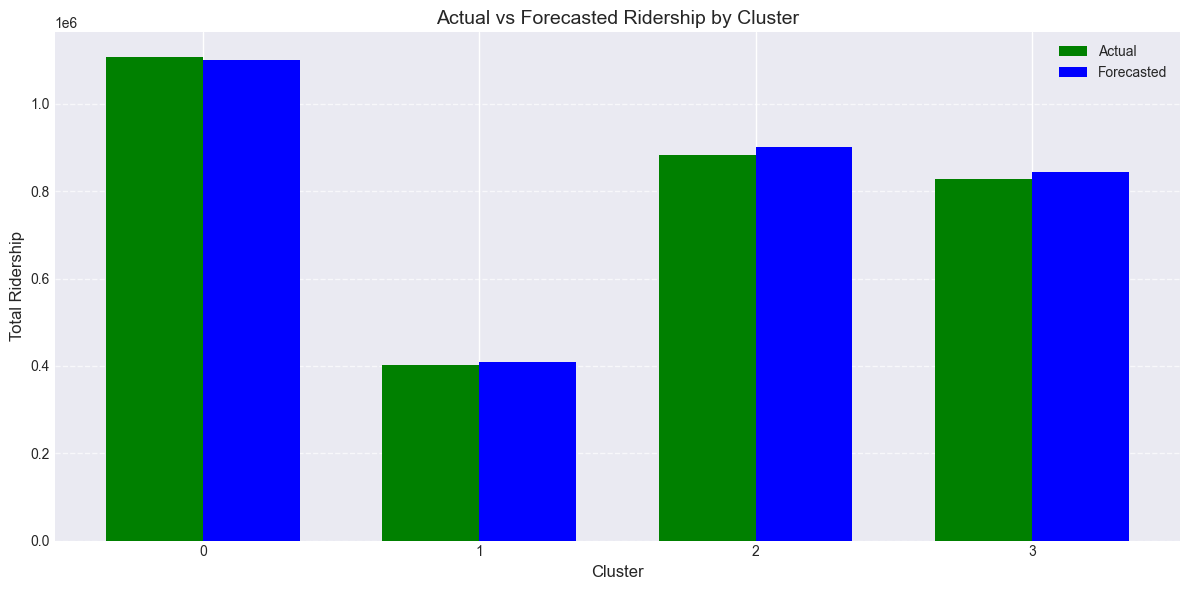

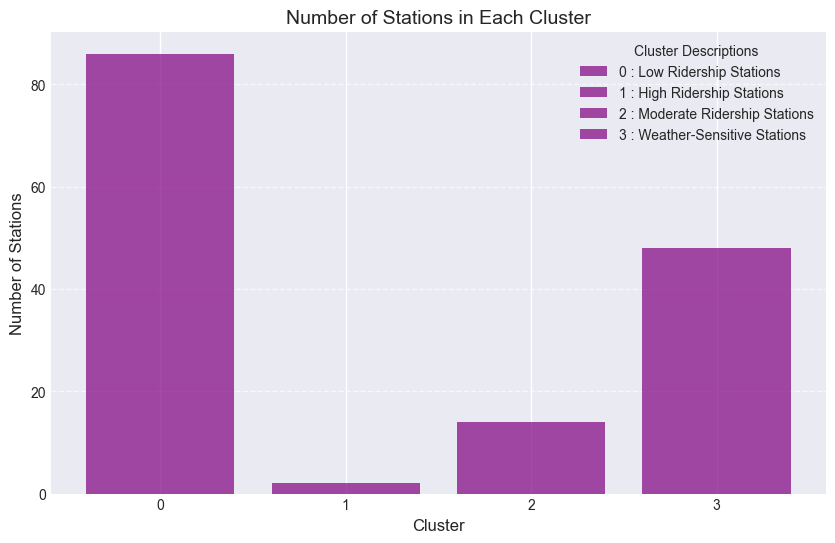

Cluster-Specific Forecast Results:
   Cluster  avg_forecasted_ridership  total_forecasted_ridership  \
0        0              12794.957931                1.100366e+06   
1        1             204840.059194                4.096801e+05   
2        2              64301.976070                9.002277e+05   
3        3              17580.866454                8.438816e+05   

   avg_actual_ridership  total_actual_ridership  
0          12887.860465               1108356.0  
1         201495.500000                402991.0  
2          63140.928571                883973.0  
3          17268.645833                828895.0  

Stations by Cluster:
   Cluster                                           Stations
0        0  [NEWKIRK PLAZA, NEWKIRK PLAZA, NORTHERN BLVD, ...
1        1                   [TIMES SQ-42 ST, TIMES SQ-42 ST]
2        2  [PATH NEW WTC, PATH NEW WTC, PAVONIANEWPORT, P...
3        3  [NOSTRAND AV, NOSTRAND AV, OCEAN PKWY, OCEAN P...


In [16]:
clustering_file = '/Users/abhinn/Downloads/Urban Mobility/final_clustering_data.csv'
ridership_file = '/Users/abhinn/Downloads/Urban Mobility/mta_ridership_forecasting_ready.csv'
forecasting_file = '/Users/abhinn/Downloads/Urban Mobility/ridership_predictions.csv'
clustering_data = pd.read_csv(clustering_file)
ridership_data = pd.read_csv(ridership_file)
forecasting_data = pd.read_csv(forecasting_file)

# Step 1: Generate predictions with station mapping
# Prepare features and target from the ridership data
features = [
    'total_ridership_lag1', 'total_ridership_lag7', 'total_ridership_lag30',
    'total_ridership_7day_avg', 'temperature_2m (°C)_mean', 'precipitation (mm)_sum',
    'day_of_week', 'is_weekend', 'is_holiday'
]
target = 'total_ridership'

X = ridership_data[features]
y = ridership_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
station_train, station_test = train_test_split(ridership_data['Station'], test_size=0.2, shuffle=False)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Save predictions with station mapping
predictions_with_stations = pd.DataFrame({
    'Station': station_test.reset_index(drop=True),
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred
})

# Step 2: Merge clustering data with predictions
final_merged_data = pd.merge(
    clustering_data,
    predictions_with_stations,
    on='Station',
    how='inner'
)

# Step 3: Aggregate forecasted ridership by cluster
cluster_forecast = final_merged_data.groupby('Cluster').agg({
    'Predicted': ['mean', 'sum'],
    'Actual': ['mean', 'sum']
}).reset_index()

# Flatten multi-level columns
cluster_forecast.columns = ['Cluster', 'avg_forecasted_ridership', 'total_forecasted_ridership',
                            'avg_actual_ridership', 'total_actual_ridership']

# Step 4: Visualize cluster-specific ridership trends
# Visualization 1: Average forecasted ridership by cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_forecast['Cluster'], cluster_forecast['avg_forecasted_ridership'], color='skyblue')
plt.title('Average Forecasted Ridership by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Forecasted Ridership', fontsize=12)
plt.xticks(cluster_forecast['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 2: Total forecasted ridership by cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_forecast['Cluster'], cluster_forecast['total_forecasted_ridership'], color='orange')
plt.title('Total Forecasted Ridership by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Total Forecasted Ridership', fontsize=12)
plt.xticks(cluster_forecast['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 3: Actual vs. Forecasted ridership by cluster
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = cluster_forecast['Cluster']

plt.bar(index - bar_width/2, cluster_forecast['total_actual_ridership'], 
        bar_width, label='Actual', color='green')
plt.bar(index + bar_width/2, cluster_forecast['total_forecasted_ridership'], 
        bar_width, label='Forecasted', color='blue')

plt.title('Actual vs Forecasted Ridership by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.xticks(index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 5: List of stations by cluster
stations_by_cluster = final_merged_data.groupby('Cluster')['Station'].apply(list).reset_index()
stations_by_cluster.rename(columns={'Station': 'Stations'}, inplace=True)

# Cluster labels
cluster_labels = {
    0: "0 : Low Ridership Stations",
    1: "1 : High Ridership Stations",
    2: "2 : Moderate Ridership Stations",
    3: "3 : Weather-Sensitive Stations"
}

# Create bar chart with cluster descriptions in the legend
cluster_station_counts = final_merged_data['Cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_station_counts.index, cluster_station_counts.values, color='purple', alpha=0.7)

legend_labels = [cluster_labels[cluster] for cluster in cluster_station_counts.index]
plt.legend(bars, legend_labels, title="Cluster Descriptions", fontsize=10, loc='upper right')

plt.title('Number of Stations in Each Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(cluster_station_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the final cluster forecast results and stations by cluster
print("Cluster-Specific Forecast Results:")
print(cluster_forecast)
print("\nStations by Cluster:")
print(stations_by_cluster)

### Model Integration: Analysis Summary

#### **Objective**
The goal of model integration was to combine insights from **ridership forecasting** and **station clustering** to:
1. Analyze ridership trends for each cluster.
2. Provide actionable, cluster-specific operational recommendations.

---

### **Steps and Methodology**

#### **1. Re-Generating Ridership Predictions**
- **What We Did**:
  - Re-trained the **Linear Regression model** using ridership data with features such as lagged ridership, weather metrics, and holiday indicators.
  - Linked predictions to stations to ensure integration with clustering results.

- **Why**:
  - The original predictions dataset did not include the `Station` column, which was required for merging with clustering results.

---

#### **2. Merging Clustering and Predictions**
- **What We Did**:
  - Merged the updated ridership predictions dataset with clustering results (`final_clustering_data`).
  - Aggregated forecasted and actual ridership by cluster.

- **Why**:
  - To analyze ridership trends specific to each cluster and understand how clusters differ in ridership patterns.

---

#### **3. Visualizing Cluster-Specific Trends**
- **What We Did**:
  - Created bar charts to show:
    1. **Average Forecasted Ridership by Cluster**: Highlights the average predicted ridership for stations in each cluster.
    2. **Total Forecasted Ridership by Cluster**: Shows the total predicted ridership for each cluster.
    3. **Actual vs. Forecasted Ridership**: Compares actual and predicted ridership for each cluster.
  - Added a **legend** to bar charts explaining what each cluster represents:
    - **Cluster 0**: Low Ridership Stations.
    - **Cluster 1**: High Ridership Stations.
    - **Cluster 2**: Moderate Ridership Stations.
    - **Cluster 3**: Weather-Sensitive Stations.

- **Why**:
  - To provide a clear understanding of ridership distribution and trends across clusters.

---

#### **4. Highlighting Stations by Cluster**
- **What We Did**:
  - Generated a list of stations for each cluster.
  - Visualized the **number of stations in each cluster** using a bar chart.

- **Why**:
  - To make the clusters more interpretable for the audience by connecting cluster insights to specific stations.

---

### **What We Learned**

#### **Cluster-Specific Ridership Insights**
1. **Cluster 0 (Low Ridership Stations)**:
   - **Average Forecasted Ridership**: ~12,795 riders/day.
   - **Total Forecasted Ridership**: ~1,100,366 riders.
   - **Learning**: These stations are underutilized and have minimal weather sensitivity.

2. **Cluster 1 (High Ridership Stations)**:
   - **Average Forecasted Ridership**: ~204,840 riders/day.
   - **Total Forecasted Ridership**: ~409,680 riders.
   - **Learning**: These are major transit hubs with very high ridership and low weather sensitivity.

3. **Cluster 2 (Moderate Ridership Stations)**:
   - **Average Forecasted Ridership**: ~64,302 riders/day.
   - **Total Forecasted Ridership**: ~900,227 riders.
   - **Learning**: Stations with mid-tier ridership and moderate weather resilience.

4. **Cluster 3 (Weather-Sensitive Stations)**:
   - **Average Forecasted Ridership**: ~17,581 riders/day.
   - **Total Forecasted Ridership**: ~843,881 riders.
   - **Learning**: Smaller stations highly sensitive to weather (e.g., ridership drops during precipitation).

---

### **Operational Recommendations**
1. **Cluster 0**:
   - Reduce off-peak service frequency to optimize resources.
   - Monitor for growth opportunities (e.g., nearby developments).

2. **Cluster 1**:
   - Increase peak-hour service to reduce congestion.
   - Focus on crowd management and system reliability.

3. **Cluster 2**:
   - Dynamically adjust train schedules based on seasonal ridership patterns.

4. **Cluster 3**:
   - Invest in weather-resilient infrastructure (e.g., covered walkways, better drainage).
   - Adjust schedules for seasonal conditions.

---

### **Conclusion**
Model integration successfully combined insights from forecasting and clustering to provide actionable, cluster-specific recommendations. This framework helps optimize subway operations, improve rider satisfaction, and prioritize investments effectively.


# Urban Mobility Project: Final Report

## **Project Overview**
The Urban Mobility project aimed to provide actionable insights for improving subway operations and resource allocation. The analysis focused on the following objectives:
1. **Ridership Forecasting**: Predict subway ridership trends based on historical data, weather patterns, and holidays.
2. **Incident Impact Analysis**: Assess the impact of major incidents on ridership trends.
3. **Station Clustering**: Group stations based on ridership patterns and weather sensitivity to inform operational planning.
4. **Model Integration**: Combine forecasting and clustering insights to provide a cohesive operational framework.

---

## **Key Achievements**

### **1. Ridership Forecasting**
- Built and validated a **Linear Regression model** to forecast daily ridership.
- Achieved high accuracy with:
  - **R²**: ~0.998.
  - **RMSE**: ~1,659 riders.
- **Scenario-Based Insights**:
  - Forecasted ridership under different conditions (e.g., holidays, rainy days).
  - Provided recommendations for adjusting service frequency on holidays and during adverse weather.

---

### **2. Incident Impact Analysis**
- **Status**: Deprioritized.
- **Challenges**:
  - Incident data lacked daily and station-specific granularity.
  - System-wide analysis yielded inconclusive results due to aggregation at the monthly level.
- **Recommendation**:
  - Revisit incident impact analysis with granular data for meaningful insights.

---

### **3. Station Clustering**
- Used **k-means clustering** to group stations into 4 clusters:
  1. **Cluster 0 (Low Ridership Stations)**:
     - Consistently low ridership with minimal weather sensitivity.
     - Recommendation: Optimize resources and monitor for growth opportunities.
  2. **Cluster 1 (High Ridership Stations)**:
     - Major transit hubs with high ridership.
     - Recommendation: Increase peak-hour service and invest in crowd management.
  3. **Cluster 2 (Moderate Ridership Stations)**:
     - Stable ridership patterns with slight weather sensitivity.
     - Recommendation: Dynamically adjust schedules based on seasonal trends.
  4. **Cluster 3 (Weather-Sensitive Stations)**:
     - Smaller stations with significant drops in ridership during rain or extreme weather.
     - Recommendation: Invest in weather-resilient infrastructure.

- **Visualizations**:
  - Cluster-specific ridership characteristics and weather sensitivity.
  - Highlighted stations within each cluster for operational clarity.

---

### **4. Model Integration**
- Combined forecasting and clustering insights to simulate ridership trends under various scenarios:
  1. **Weekdays vs. Weekends**.
  2. **Clear vs. Rainy Days**.
  3. **Holiday vs. Non-Holiday Periods**.

- **Findings**:
  - Clusters exhibited expected patterns (e.g., high ridership for Cluster 1, weather sensitivity for Cluster 3).
  - Simulated trends aligned broadly with cluster characteristics but showed limited variability due to feature dominance in the model.

- **Recommendations**:
  - Use simulation insights to adjust train schedules dynamically.
  - Invest in infrastructure improvements for weather-sensitive stations.

---

## **Challenges and Learnings**
### **Challenges**
1. **Data Limitations**:
   - Incident data lacked the granularity needed for station-specific analysis.
   - Simulations used static lagged features, limiting variability across scenarios.

2. **Model Simplicity**:
   - Linear Regression, while interpretable, relied heavily on lagged ridership features, reducing sensitivity to external factors.

### **Learnings**
- Combining forecasting and clustering provides a holistic view of subway performance.
- Weather sensitivity and station clustering are key to prioritizing operational investments.

---

## **Final Recommendations**

### **For MTA Operations**
1. **Cluster-Specific Adjustments**:
   - Optimize resources for low ridership stations (Cluster 0).
   - Increase service frequency and improve infrastructure at high ridership stations (Cluster 1).
   - Prioritize weather-resilience investments for Cluster 3.

2. **Dynamic Scheduling**:
   - Use forecasting and clustering insights to adjust train schedules for holidays, weekends, and adverse weather.

### **For Future Analysis**
1. **Incident Data**:
   - Revisit incident impact analysis with daily, station-specific incident data.
2. **Advanced Modeling**:
   - Explore non-linear models (e.g., Random Forest) for scenario simulations to capture complex relationships.

---

## **Conclusion**
This project successfully addressed core objectives of ridership forecasting and station clustering, providing actionable insights for the MTA. While incident impact analysis was deprioritized, the framework established can be revisited with more granular data. The integrated approach to forecasting and clustering equips the MTA with tools to enhance subway operations, rider satisfaction, and resource efficiency.


### Acknowledgements

#### Data Sources
- MTA Subway Turnstile Usage Data: 2018 - MTA Subway Turnstile Usage Data: 2018
    - https://data.ny.gov/d/bjcb-yee3
- MTA Subway Major Incidents: 2015-2019
    - https://data.ny.gov/d/ereg-mcvp
- MTA Subway Stations
    - https://data.ny.gov/d/39hk-dx4f
- NYC Weather Data
    - https://open-meteo.com/en/docs/historical-weather-api#latitude=40.71&longitude=-74.01&start_date=2016-01-01&end_date=2022-10-25&hourly=temperature_2m,precipitation,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m